In [101]:
from abc import ABC, abstractmethod
from scipy.stats import gaussian_kde
import numpy as np
import math
import sys
import os
import glob
import gym
from collections import deque
from time import time
from datetime import timedelta
import pickle
from base64 import b64encode
import torch
from torch import nn
from torch.distributions import Normal
import torch.nn.functional as F
from sklearn.decomposition import PCA

In [393]:
# figureの基本設定．ノートブック上では大きめに出力されるが，パワポに張り付けるときれいになるように設定している．
%matplotlib inline 
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [25/25.4, 25/25.4] #??mm/25.4で書く
plt.rcParams['font.size'] = 7 #フォントサイズを設定 default : 12
plt.rcParams['xtick.labelsize'] = 7 # 横軸のフォントサイズ
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams["xtick.major.size"] = 2.26772      # x軸主目盛り線の長さ(単位ポイント)
plt.rcParams["ytick.major.size"] = 2.26772      # y軸主目盛り線の長さ
plt.rcParams["xtick.major.width"] = 0.566929     # x軸主目盛り線の線幅
plt.rcParams["ytick.major.width"] = 0.566929     # y軸主目盛り線の線幅
plt.rcParams["axes.linewidth"] = 0.566929        # グラフ囲う線の太さ
plt.rcParams["figure.dpi"] = 600            # dpi(dots per inch)
plt.rcParams["xtick.minor.visible"] = False # x軸副目盛り線を描くかどうか
plt.rcParams["ytick.minor.visible"] = False # y軸副目盛り線を描くかどうか
plt.rcParams["xtick.minor.size"] = 2.26772/2      # x軸副目盛り線の長さ
plt.rcParams["ytick.minor.size"] = 2.26772/2      # y軸副目盛り線の長さ
plt.rcParams["xtick.minor.width"] = 0.566929     # x軸副目盛り線の線幅
plt.rcParams["ytick.minor.width"] = 0.566929     # y軸副目盛り線の線幅
plt.rcParams["axes.spines.bottom"] = True
plt.rcParams["axes.spines.left"] = True
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["lines.linewidth"] = 0.3401575

In [ ]:
torch.cuda.is_available()

### Sompolinsky1988 modelを$10^5$タイムステップ分計算してみる
##### https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.61.259

In [1]:
np.random.seed(0)
N = 128
JJ = 1.5 #if J>1 chaos

J = np.random.randn(N, N) * JJ / np.sqrt(N)
J = J - np.diag(np.diag(J))

T = 10 ** 5
epsilon = 0.3

X = np.zeros((N, T))
Xout = np.zeros((N, T))
E=np.zeros((128,T-1))
X[:, 0] = np.reshape(np.random.randn(N, 1),N)
Xout[:, 0] = X[:, 0]
for t in range(T-1):
    t += 1
    e = np.reshape(epsilon * np.random.randn(N, 1),N)
    X[:, t] = np.dot(J, Xout[:, t-1]) + e
    Xout[:, t] = np.tanh(X[:, t])
    E[:,t-1]=e

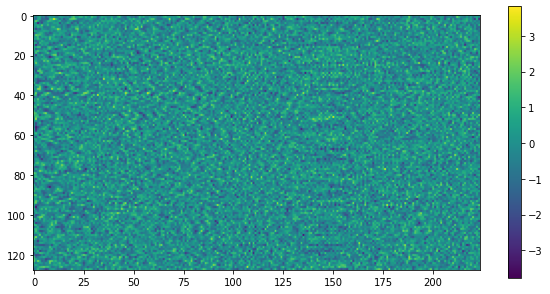

In [5]:
plt.figure(figsize=(10,5))
plt.imshow(X[:,0:224])
plt.colorbar()

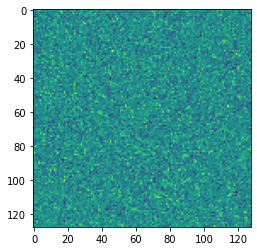

In [6]:
# 結合強度の可視化
plt.imshow(J)

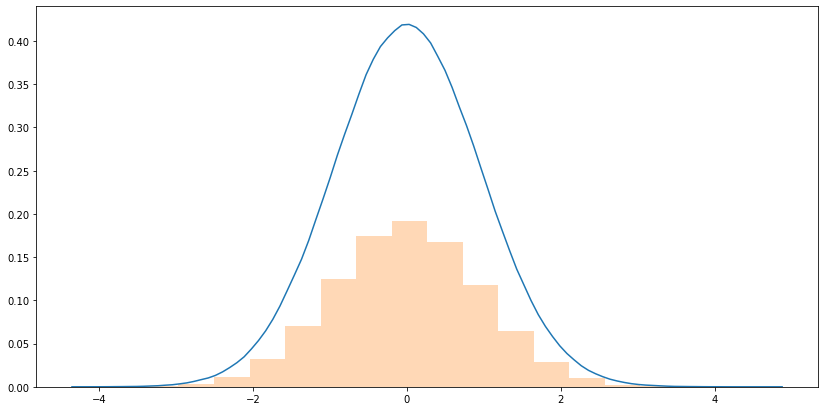

In [20]:
# Unit Activityの分布
T_end = 10**4
x_grid = np.linspace(min(X[:,:T_end].ravel()), max(X[:,:T_end].ravel()), num=100)
kde_model = gaussian_kde(X[:,:T_end].ravel())
y = kde_model(x_grid)

weights = np.ones_like(X[:,:T_end].ravel())/float(len(X[:,:T_end].ravel()))
plt.figure(figsize=(14,7))
plt.plot(x_grid, y)
plt.hist(X[:,:T_end].ravel(), alpha=0.3, bins=20, weights=weights)
plt.show()

### 第何主成分までで分散説明率が8割を超えるか求める

In [7]:
pca = PCA(n_components=128)
pca.fit(X[:128,:].T)

PCA(n_components=128)

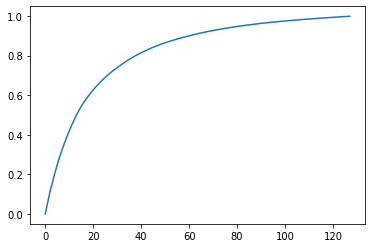

In [13]:
# 累積グラフ
cum = [pca.explained_variance_ratio_[:i].sum() for i in range(128)]
plt.plot(cum)

In [41]:
# PCA後の次元のデフォルトを決定
DIM_PCA = np.where(np.array(cum)>0.8)[0][0] + 1

### OpneAI Gymの自前環境を作る

In [298]:
N_UNITS = 128

class SompolinskyEnv(gym.Env):
    """
    参考 https://qiita.com/ohtaman/items/edcb3b0a2ff9d48a7def
    設定必須な関数
    step(self, action)：action を実行し、結果を返す
    reset(self)：状態を初期化し、初期の観測値を返す
    render(self, mode='human', close=False)：環境を可視化する
    設定準必須な関数
    close(self)：環境を閉じて後処理をする
    seed(self, seed=None)：ランダムシードを固定する
    設定必須なプロパティ
    action_space：行動(Action)の張る空間
    observation_space：観測値(Observation)の張る空間
    # reward_range：報酬の最小値と最大値のリスト．なくてもよいかもしれない
    """

    def __init__(self, Max_stim, N_stim_units, Max_state, N_units=N_UNITS,
                 JJ=1.5, seed_synapse=0, seed_state=1, N_obs=128, epsilon=0.3, T=10**5,
                 reward_mode='target', reward_target=np.zeros((N_UNITS,)), T_render=256, dim_pca=DIM_PCA):
        super(SompolinskyEnv, self).__init__()
        # action_space, observation_space, reward_range を設定する
        self.Max_stim = Max_stim
        self.N_stim_units = N_stim_units
        self.Max_state = Max_state
        self.N_units = N_units
        self.JJ = JJ
        self.seed_synapse = seed_synapse
        self.seed_state = seed_state
        self.N_obs = N_obs
        self.epsilon = epsilon
        self._max_episode_steps = T # 1エピソードの終了時間
        self.reward_target = reward_target.astype(np.float32)
        self.dim_pca = dim_pca
        assert len(self.reward_target) == self.N_units, 'target len must be equal as N_units'
        assert self.N_units >= self.N_obs, 'N_obs must be N_units or lower'
        self.reward_mode = reward_mode # 'target' or 'PCA'
        self.T_render = T_render
        self.action_space = gym.spaces.Box(low=-self.Max_stim, high=self.Max_stim, shape=(self.N_stim_units,))
        self.observation_space = gym.spaces.Box(low=-self.Max_state, high=self.Max_state, shape=(self.N_obs,))
        #self.reward_range = [0., 1.]
        self.seed(self.seed_synapse)
        self.J = self.set_synaptic_strength(N=self.N_units, JJ=self.JJ)
        self.reset()

    def reset(self):
        # 諸々の変数を初期化する
        #self.seed(self.seed_state)
        self.X = np.reshape(np.random.randn(self.N_units, 1),self.N_units).astype(np.float32)
        self.X_render = np.zeros((self.N_units, self.T_render)) # render用
        self.X_render[:,-1] = self.X
        self.obs_idx = np.random.choice(np.arange(self.N_units), size=self.N_obs, replace=False) # 観測できるニューロンのindex
        self.done = False
        self.steps = 0
        if self.reward_mode=='PCA':
            self.X_pca = np.zeros((self.N_units, self._max_episode_steps))
            self.X_pca[:, 0] = self.X
            for t in range(self._max_episode_steps-1):
                t += 1
                e = np.reshape(self.epsilon * np.random.randn(self.N_units, 1),self.N_units)
                self.X_pca[:, t] = np.tanh(np.dot(self.J, self.X_pca[:, t-1]) + e)
            self.pca = PCA(n_components=self.dim_pca)
            self.pca.fit(self.X_pca.T)
        return self.X[self.obs_idx]

    def step(self, action):
        # 1ステップ進める処理を記述。戻り値は observation, reward, done(ゲーム終了したか), info(追加の情報の辞書)
        e = np.reshape(self.epsilon * np.random.randn(self.N_units, 1),self.N_units) #ノイズ項
        self.X = np.tanh(np.dot(self.J, self.X+np.pad(action, [0,self.N_units - self.N_stim_units], 'constant')) + e) # 1ステップ進める

        observation = self.X[self.obs_idx]
        self.X_render = np.roll(self.X_render, -1, axis=1) # 1つ左にシフトして
        self.X_render[:,-1] = self.X                  # 一番右に現在の値を格納
        reward = self.get_reward(self.X, self.reward_mode)
        self.steps += 1
        self.done = self.is_done()
        return observation, reward, self.done, {}

    def render(self, mode='human', close=False):
        # human の場合はコンソールに出力
        
        if mode == 'human':
            plt.figure(figsize=(10,5))
            plt.imshow(self.X_render)
            plt.colorbar()

        elif mode == 'raw':
            return self.X_render
        else:
            raise NotImplementedError
            
    def close(self):
        pass

    def seed(self, seed=0):
        np.random.seed(seed)
    
    def set_synaptic_strength(self, N, JJ):
        """
        Input；
        N：n_units
        JJ：複雑性の指標 if J>1 chaos
        
        Iutput；
        N個のニューロン同士の全結合パターンのシナプス重み行列を返す（J）
        """

        J = np.random.randn(N, N) * JJ / np.sqrt(N)
        J = J - np.diag(np.diag(J))
        return J.astype(np.float32)

    def get_reward(self, X, reward_mode):
        # 報酬を返す。報酬の与え方が難しいが、ここでは
        if reward_mode=='target':
            mse = ((X - self.reward_target)**2).mean()
            return -mse
        elif reward_mode=='PCA':
            X_transformed = self.pca.transform(X.reshape(1,-1))
            X_transformed /= np.sum(X_transformed) # 単に過活動になることが報酬にならないように規格化
            diversity = np.sum([np.abs(x)*(1-self.pca.explained_variance_ratio_[i]) for i,x in enumerate(X_transformed)]) # 寄与率の低い主成分ほど報酬weightを大きくする
            return diversity

    def is_done(self):
        # 今回は最大で self._max_episode_steps
        return False if self.steps < self._max_episode_steps else True

In [242]:
N_UNITS = 2**7
N_STIM_UNITS = 32
N_OBS = 32
env = SompolinskyEnv(Max_stim=1, N_stim_units=N_STIM_UNITS, Max_state=5, N_units=N_UNITS,
                     JJ=0.5, seed_synapse=0, seed_state=1, N_obs=N_OBS, epsilon=0.3, T=10**5,
                     reward_mode='target', reward_target=np.zeros((N_UNITS,)), T_render=256, dim_pca=DIM_PCA)

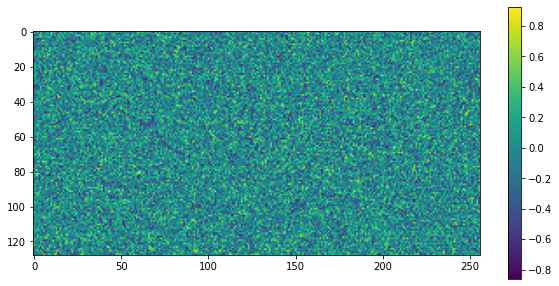

In [243]:
for i in range(10**5):
    #action = env.action_space.sample()
    action = np.zeros((env.action_space.shape[0], ))
    observation, reward, done, _ = env.step(action)
env.render()

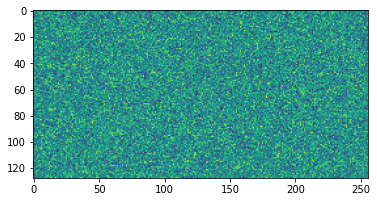

In [217]:
# envが保持しているrender用の変数からも同様に可視化可能
plt.imshow(env.X_render[:128])

# モデルフリー強化学習の実装
##### 今回はPPOを試す

In [299]:
class Trainer:

    def __init__(self, env, env_test, algo, seed=0, num_steps=10**6, eval_interval=10**4, num_eval_episodes=3):

        self.env = env
        self.env_test = env_test
        self.algo = algo

        # 環境の乱数シードを設定する．
        self.env.seed(seed)
        self.env_test.seed(2**31-seed)

        # 平均収益を保存するための辞書．
        self.returns = {'step': [], 'return_train': [], 'return_val': []}

        # データ収集を行うステップ数．
        self.num_steps = num_steps
        # 評価の間のステップ数(インターバル)．
        self.eval_interval = eval_interval
        # 評価を行うエピソード数．
        self.num_eval_episodes = num_eval_episodes

    def train(self):
        """ num_stepsステップの間，データ収集・学習・評価を繰り返す． """

        # 学習開始の時間
        self.start_time = time()
        # エピソードのステップ数．
        t = 0

        # 環境を初期化する．
        state = self.env.reset()

        for steps in range(1, self.num_steps + 1):
            # 環境(self.env)，現在の状態(state)，現在のエピソードのステップ数(t)，今までのトータルのステップ数(steps)を
            # アルゴリズムに渡し，状態・エピソードのステップ数を更新する．
            state, t = self.algo.step(self.env, state, t, steps)

            # アルゴリズムが準備できていれば，1回学習を行う．
            if self.algo.is_update(steps):
                self.algo.update()

            # 一定のインターバルで評価する．
            if steps % self.eval_interval == 0:
                self.evaluate(steps)

    def evaluate(self, steps):
        """ 複数エピソード環境を動かし，平均収益を記録する． """

        returns_train = []
        returns_val = []
        for _ in range(self.num_eval_episodes):
            state_train = self.env.reset()
            state_val = self.env_test.reset()
            done_train = False
            done_val = False
            episode_return_train = 0.0
            episode_return_val = 0.0

            while (not done_train):
                action_train = self.algo.exploit(state_train)
                state_train, reward, done_train, _ = self.env.step(action_train)
                episode_return_train += reward
            while (not done_val):
                action_val = self.algo.exploit(state_val)
                state_val, reward, done_val, _ = self.env_test.step(action_val)
                episode_return_val += reward

            returns_train.append(episode_return_train)
            returns_val.append(episode_return_val)

        mean_return_train = np.mean(returns_train)
        mean_return_val = np.mean(returns_val)
        self.returns['step'].append(steps)
        self.returns['return_train'].append(mean_return_train)
        self.returns['return_val'].append(mean_return_val)

        print(f'Num steps: {steps:<6}   '
              f'Return_train: {mean_return_train:<5.1f}   '
              f'Return_val: {mean_return_val:<5.1f}   '
              f'Time: {self.time}')

    def visualize(self):
        """ 1エピソード環境を動かし，最後の神経活動を可視化する． """
        env = SompolinskyEnv(Max_stim=self.env.Max_stim, N_stim_units=self.env.N_stim_units, Max_state=self.env.Max_state, N_units=self.env.N_units,
                             JJ=self.env.JJ, seed_synapse=self.env.seed_synapse, seed_state=self.env.seed_state, N_obs=self.env.N_obs, epsilon=self.env.epsilon, T=self.env._max_episode_steps, 
                             reward_mode=self.env.reward_mode, reward_target=self.env.reward_target, T_render=self.env.T_render, dim_pca=self.env.dim_pca)
        state = env.reset()
        done = False

        while (not done):
            action = self.algo.exploit(state)
            state, _, done, _ = env.step(action)
        env.render()
        del env

    def plot(self):
        """ 平均収益のグラフを描画する． """
        fig = plt.figure(figsize=(8, 6))
        plt.plot(self.returns['step'], self.returns['return_train'])
        plt.plot(self.returns['step'], self.returns['return_val'])
        plt.xlabel('Steps', fontsize=24)
        plt.ylabel('Return', fontsize=24)
        plt.tick_params(labelsize=18)
        #plt.title(f'{self.env.unwrapped.spec.id}', fontsize=24)
        plt.tight_layout()

    @property
    def time(self):
        """ 学習開始からの経過時間． """
        return str(timedelta(seconds=int(time() - self.start_time)))

In [300]:
class Algorithm(ABC):

    def explore(self, state):
        """ 確率論的な行動と，その行動の確率密度の対数 \log(\pi(a|s)) を返す． """
        state = torch.tensor(state, dtype=torch.float, device=self.device).unsqueeze_(0)
        with torch.no_grad():
            action, log_pi = self.actor.sample(state)
        return action.cpu().numpy()[0], log_pi.item()

    def exploit(self, state):
        """ 決定論的な行動を返す． """
        state = torch.tensor(state, dtype=torch.float, device=self.device).unsqueeze_(0)
        with torch.no_grad():
            action = self.actor(state)
        return action.cpu().numpy()[0]

    @abstractmethod
    def is_update(self, steps):
        """ 現在のトータルのステップ数(steps)を受け取り，アルゴリズムを学習するか否かを返す． """
        pass

    @abstractmethod
    def step(self, env, state, t, steps):
        """ 環境(env)，現在の状態(state)，現在のエピソードのステップ数(t)，今までのトータルのステップ数(steps)を
            受け取り，リプレイバッファへの保存などの処理を行い，状態・エピソードのステップ数を更新する．
        """
        pass

    @abstractmethod
    def update(self):
        """ 1回分の学習を行う． """
        pass

In [301]:
def calculate_log_pi(log_stds, noises, actions):
    """ 確率論的な行動の確率密度を返す． """
    # ガウス分布 `N(0, stds * I)` における `noises * stds` の確率密度の対数(= \log \pi(u|a))を計算する．
    # (torch.distributions.Normalを使うと無駄な計算が生じるので，下記では直接計算しています．)
    gaussian_log_probs = \
        (-0.5 * noises.pow(2) - log_stds).sum(dim=-1, keepdim=True) - 0.5 * math.log(2 * math.pi) * log_stds.size(-1)

    # tanh による確率密度の変化を修正する．
    log_pis = gaussian_log_probs - torch.log(1 - actions.pow(2) + 1e-6).sum(dim=-1, keepdim=True)

    return log_pis

In [302]:
def reparameterize(means, log_stds):
    """ Reparameterization Trickを用いて，確率論的な行動とその確率密度を返す． """
    # 標準偏差．
    stds = log_stds.exp()
    # 標準ガウス分布から，ノイズをサンプリングする．
    noises = torch.randn_like(means)
    # Reparameterization Trickを用いて，N(means, stds)からのサンプルを計算する．
    us = means + noises * stds
    # tanh　を適用し，確率論的な行動を計算する．
    actions = torch.tanh(us)

    # 確率論的な行動の確率密度の対数を計算する．
    log_pis = calculate_log_pi(log_stds, noises, actions)

    return actions, log_pis

In [303]:
def atanh(x):
    """ tanh の逆関数． """
    return 0.5 * (torch.log(1 + x + 1e-6) - torch.log(1 - x + 1e-6))


def evaluate_lop_pi(means, log_stds, actions):
    """ 平均(mean)，標準偏差の対数(log_stds)でパラメータ化した方策における，行動(actions)の確率密度の対数を計算する． """
    noises = (atanh(actions) - means) / (log_stds.exp() + 1e-8)
    return calculate_log_pi(log_stds, noises, actions)

In [304]:
class PPOActor(nn.Module):

    def __init__(self, state_shape, action_shape):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(state_shape[0], 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, action_shape[0]),
        )
        self.log_stds = nn.Parameter(torch.zeros(1, action_shape[0]))

    def forward(self, states):
        return torch.tanh(self.net(states))

    def sample(self, states):
        return reparameterize(self.net(states), self.log_stds)

    def evaluate_log_pi(self, states, actions):
        return evaluate_lop_pi(self.net(states), self.log_stds, actions)

In [305]:
class PPOCritic(nn.Module):

    def __init__(self, state_shape):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(state_shape[0], 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
        )

    def forward(self, states):
        return self.net(states)

In [306]:
def calculate_advantage(values, rewards, dones, next_values, gamma=0.995, lambd=0.997):
    """ GAEを用いて，状態価値のターゲットとGAEを計算する． """

    # TD誤差を計算する．
    deltas = rewards + gamma * next_values * (1 - dones) - values

    # GAEを初期化する．
    advantages = torch.empty_like(rewards)

    # 終端ステップを計算する．
    advantages[-1] = deltas[-1]

    # 終端ステップの1つ前から，順番にGAEを計算していく．
    for t in reversed(range(rewards.size(0) - 1)):
        advantages[t] = deltas[t] + gamma * lambd * (1 - dones[t]) * advantages[t + 1]

    # 状態価値のターゲットをλ-収益として計算する．
    targets = advantages + values

    # GAEを標準化する．
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    return targets, advantages

In [307]:
class RolloutBuffer:

    def __init__(self, buffer_size, state_shape, action_shape, device=torch.device('cuda:0')):

        # GPU上に保存するデータ．
        self.states = torch.empty((buffer_size, *state_shape), dtype=torch.float, device=device)
        self.actions = torch.empty((buffer_size, *action_shape), dtype=torch.float, device=device)
        self.rewards = torch.empty((buffer_size, 1), dtype=torch.float, device=device)
        self.dones = torch.empty((buffer_size, 1), dtype=torch.float, device=device)
        self.log_pis = torch.empty((buffer_size, 1), dtype=torch.float, device=device)
        self.next_states = torch.empty((buffer_size, *state_shape), dtype=torch.float, device=device)

        # 次にデータを挿入するインデックス．
        self._p = 0
        # バッファのサイズ．
        self.buffer_size = buffer_size

    def append(self, state, action, reward, done, log_pi, next_state):
        self.states[self._p].copy_(torch.from_numpy(state))
        self.actions[self._p].copy_(torch.from_numpy(action))
        self.rewards[self._p] = float(reward)
        self.dones[self._p] = float(done)
        self.log_pis[self._p] = float(log_pi)
        self.next_states[self._p].copy_(torch.from_numpy(next_state))
        self._p = (self._p + 1) % self.buffer_size
    
    def get(self):
        assert self._p == 0, 'Buffer needs to be full before training.'
        return self.states, self.actions, self.rewards, self.dones, self.log_pis, self.next_states

In [308]:
class PPO(Algorithm):

    def __init__(self, state_shape, action_shape, device=torch.device('cuda:0'), seed=0,
                 batch_size=64, gamma=0.995, lr_actor=3e-4, lr_critic=3e-4,
                 rollout_length=10**3, num_updates=10, clip_eps=0.2, lambd=0.97,
                 coef_ent=0.0, max_grad_norm=0.5):
        super().__init__()

        # シードを設定する．
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)

        # データ保存用のバッファ．
        self.buffer = RolloutBuffer(
            buffer_size=rollout_length,
            state_shape=state_shape,
            action_shape=action_shape,
            device=device
        )

        # Actor-Criticのネットワークを構築する．
        self.actor = PPOActor(
            state_shape=state_shape,
            action_shape=action_shape,
        ).to(device)
        self.critic = PPOCritic(
            state_shape=state_shape,
        ).to(device)

        # オプティマイザ．
        self.optim_actor = torch.optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.optim_critic = torch.optim.Adam(self.critic.parameters(), lr=lr_critic)

        # その他パラメータ．
        self.learning_steps = 0
        self.device = device
        self.batch_size = batch_size
        self.gamma = gamma
        self.rollout_length = rollout_length
        self.num_updates = num_updates
        self.clip_eps = clip_eps
        self.lambd = lambd
        self.coef_ent = coef_ent
        self.max_grad_norm = max_grad_norm

    def is_update(self, steps):
        # ロールアウト1回分のデータが溜まったら学習する．
        return steps % self.rollout_length == 0

    def step(self, env, state, t, steps):
        t += 1

        action, log_pi = self.explore(state)
        next_state, reward, done, _ = env.step(action)

        if t == env._max_episode_steps:
            done_masked = False
        else:
            done_masked = done

        # バッファにデータを追加する．
        self.buffer.append(state, action, reward, done_masked, log_pi, next_state)

        # エピソードが終了した場合には，環境をリセットする．
        if done:
            t = 0
            next_state = env.reset()

        return next_state, t

    def update(self):
        self.learning_steps += 1

        states, actions, rewards, dones, log_pis, next_states = self.buffer.get()

        with torch.no_grad():
            values = self.critic(states)
            next_values = self.critic(next_states)
        targets, advantages = calculate_advantage(values, rewards, dones, next_values, self.gamma, self.lambd)

        # バッファ内のデータを num_updates回ずつ使って，ネットワークを更新する．
        for _ in range(self.num_updates):
            # インデックスをシャッフルする．
            indices = np.arange(self.rollout_length)
            np.random.shuffle(indices)

            # ミニバッチに分けて学習する．
            for start in range(0, self.rollout_length, self.batch_size):
                idxes = indices[start:start+self.batch_size]
                self.update_critic(states[idxes], targets[idxes])
                self.update_actor(states[idxes], actions[idxes], log_pis[idxes], advantages[idxes])

    def update_critic(self, states, targets):
        loss_critic = (self.critic(states) - targets).pow_(2).mean()

        self.optim_critic.zero_grad()
        loss_critic.backward(retain_graph=False)
        # 学習を安定させるヒューリスティックとして，勾配のノルムをクリッピングする．
        nn.utils.clip_grad_norm_(self.critic.parameters(), self.max_grad_norm)
        self.optim_critic.step()

    def update_actor(self, states, actions, log_pis_old, advantages):
        log_pis = self.actor.evaluate_log_pi(states, actions)
        mean_entropy = -log_pis.mean()

        ratios = (log_pis - log_pis_old).exp_()
        loss_actor1 = -ratios * advantages
        loss_actor2 = -torch.clamp(
            ratios,
            1.0 - self.clip_eps,
            1.0 + self.clip_eps
        ) * advantages
        loss_actor = torch.max(loss_actor1, loss_actor2).mean() - self.coef_ent * mean_entropy

        self.optim_actor.zero_grad()
        loss_actor.backward(retain_graph=False)
        # 学習を安定させるヒューリスティックとして，勾配のノルムをクリッピングする．
        nn.utils.clip_grad_norm_(self.actor.parameters(), self.max_grad_norm)
        self.optim_actor.step()

### trainingを1モデルで回してみる

In [340]:
# 訓練の設定
NUM_STEPS = 10 ** 6
EVAL_INTERVAL = 5 * 10 ** 3

# 環境の設定
N_UNITS = 128
MAX_STIM = 1.0
SEED = 0 #初期状態のシード．シナプス結合のシードはテスト環境も同じにしている．
JJ_DEF = 1.5
ROLLOUT_LENGTH = 10 ** 3
N_STIM_UNITS = 128
N_OBS = 128
EPSILON = 0
T_RENDER = 256

env = SompolinskyEnv(Max_stim=MAX_STIM, N_stim_units=N_STIM_UNITS, Max_state=5, N_units=N_UNITS,
                     JJ=JJ_DEF, seed_synapse=0, seed_state=SEED, N_obs=N_OBS, epsilon=EPSILON , T=ROLLOUT_LENGTH,
                     reward_mode='PCA', reward_target=np.zeros((N_UNITS,)), T_render=T_RENDER, dim_pca=DIM_PCA) # reward_target=np.linspace(-1, 1, N_UNITS)
env_test = SompolinskyEnv(Max_stim=MAX_STIM, N_stim_units=N_STIM_UNITS, Max_state=5, N_units=N_UNITS,
                     JJ=JJ_DEF, seed_synapse=0, seed_state=(2**31-SEED), N_obs=N_OBS, epsilon=EPSILON , T=ROLLOUT_LENGTH,
                     reward_mode='PCA', reward_target=np.zeros((N_UNITS,)), T_render=T_RENDER, dim_pca=DIM_PCA)

algo = PPO(
    state_shape=env.observation_space.shape,
    action_shape=env.action_space.shape,
    seed=SEED,
    rollout_length=ROLLOUT_LENGTH
)

trainer = Trainer(
    env=env,
    env_test=env_test, # envを入れることでトレーニングのスコアを確認する
    algo=algo,
    seed=SEED,
    num_steps=NUM_STEPS,
    eval_interval=EVAL_INTERVAL,
)

In [341]:
trainer.train()

Num steps: 5000     Return_train: 23450.9   Return_val: 25149.6   Time: 0:00:16
Num steps: 10000    Return_train: 33706.2   Return_val: 9782.1   Time: 0:00:35
Num steps: 15000    Return_train: 31853.9   Return_val: 61623.6   Time: 0:00:53
Num steps: 20000    Return_train: 26091.0   Return_val: 50904.6   Time: 0:01:11
Num steps: 25000    Return_train: 29582.0   Return_val: 45238.9   Time: 0:01:30
Num steps: 30000    Return_train: 22190.6   Return_val: 113224.1   Time: 0:01:47
Num steps: 35000    Return_train: 52974.5   Return_val: 22400.8   Time: 0:02:04
Num steps: 40000    Return_train: 124741.7   Return_val: 24441.6   Time: 0:02:23
Num steps: 45000    Return_train: 55259.5   Return_val: 9536.4   Time: 0:02:40
Num steps: 50000    Return_train: 19587.1   Return_val: 29150.9   Time: 0:02:58
Num steps: 55000    Return_train: 43101.3   Return_val: 89411.2   Time: 0:03:17
Num steps: 60000    Return_train: 25745.9   Return_val: 21159.6   Time: 0:03:35
Num steps: 65000    Return_train: 72895.

Num steps: 520000   Return_train: 82741.1   Return_val: 27283.2   Time: 0:31:21
Num steps: 525000   Return_train: 34372.6   Return_val: 53021.7   Time: 0:31:40
Num steps: 530000   Return_train: 20489.4   Return_val: 23290.9   Time: 0:31:58
Num steps: 535000   Return_train: 47207.1   Return_val: 28975.5   Time: 0:32:16
Num steps: 540000   Return_train: 50118.2   Return_val: 42486.9   Time: 0:32:34
Num steps: 545000   Return_train: 14190.8   Return_val: 27436.5   Time: 0:32:53
Num steps: 550000   Return_train: 45003.4   Return_val: 205817.7   Time: 0:33:12
Num steps: 555000   Return_train: 35551.2   Return_val: 23191.4   Time: 0:33:31
Num steps: 560000   Return_train: 92648.9   Return_val: 27401.7   Time: 0:33:49
Num steps: 565000   Return_train: 30941.7   Return_val: 33102.4   Time: 0:34:09
Num steps: 570000   Return_train: 28910.9   Return_val: 23276.5   Time: 0:34:28
Num steps: 575000   Return_train: 64032.4   Return_val: 39059.9   Time: 0:34:46
Num steps: 580000   Return_train: 27622

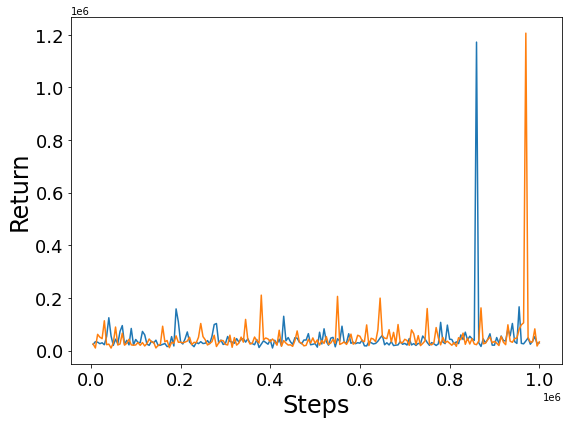

In [342]:
# 学習曲線の可視化
trainer.plot()

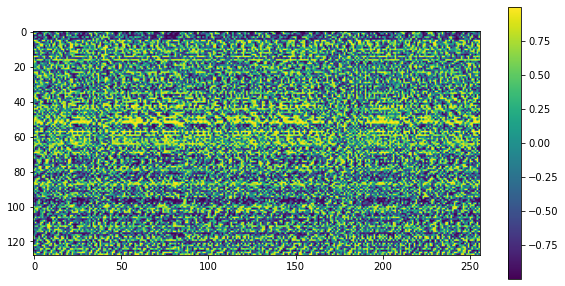

In [343]:
# render
trainer.visualize()

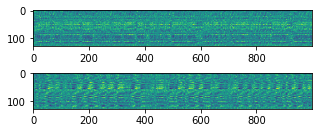

In [344]:
# 訓練環境，テスト環境それぞれ可視化．256時刻分まで出なく最初から1エピソード全て可視化
# train
state = env.reset()
done = False

render_episode_train = np.zeros((env.N_units, env._max_episode_steps))
i = 0
j = 0
while (not done):
    action = algo.exploit(state) # np.zeros((env.action_space.shape[0],)) 
    state, _, done, _ = env.step(action)
    i += 1
    if i % env.T_render==0:
        render_episode_train[:,j*env.T_render:(j+1)*env.T_render] = env.render(mode='raw')
        j += 1
render_episode_train[:,-env.T_render:] = env.render(mode='raw')
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(2, 1, 1)
ax1.imshow(render_episode_train)

# test
state = env_test.reset()
done = False

render_episode_test = np.zeros((env_test.N_units, env_test._max_episode_steps))
i = 0
j = 0
while (not done):
    action = algo.exploit(state)
    state, _, done, _ = env_test.step(action)
    i += 1
    if i % env_test.T_render==0:
        render_episode_test[:,j*env_test.T_render:(j+1)*env_test.T_render] = env_test.render(mode='raw')
        j += 1
render_episode_test[:,-env_test.T_render:] = env_test.render(mode='raw')
ax2 = fig.add_subplot(2, 1, 2)
ax2.imshow(render_episode_test)
plt.subplots_adjust(wspace=0.4, hspace=-0.7)

# パラメタ，seedを変えて学習曲線，visualizationを保存

In [349]:
def render_episode(env, env_test, algo):
    state = env.reset()
    done = False

    render_episode_train = np.zeros((env.N_units, env._max_episode_steps))
    i = 0
    j = 0
    while (not done):
        action = algo.exploit(state) # np.zeros((env.action_space.shape[0],)) 
        state, _, done, _ = env.step(action)
        i += 1
        if i % env.T_render==0:
            render_episode_train[:,j*env.T_render:(j+1)*env.T_render] = env.render(mode='raw')
            j += 1
    render_episode_train[:,-env.T_render:] = env.render(mode='raw')

    # test
    state = env_test.reset()
    done = False

    render_episode_test = np.zeros((env_test.N_units, env_test._max_episode_steps))
    i = 0
    j = 0
    while (not done):
        action = algo.exploit(state)
        state, _, done, _ = env_test.step(action)
        i += 1
        if i % env_test.T_render==0:
            render_episode_test[:,j*env_test.T_render:(j+1)*env_test.T_render] = env_test.render(mode='raw')
            j += 1
    render_episode_test[:,-env_test.T_render:] = env_test.render(mode='raw')
    return render_episode_train, render_episode_test

def training_func(JJ_DEF, REWARD_MODE, N_OBS, EPSILON, SEED):
    # 訓練の設定
    NUM_STEPS = 10 ** 6
    EVAL_INTERVAL = 5 * 10 ** 3

    # 環境の設定
    N_UNITS = 128
    MAX_STIM = 1.0
    ROLLOUT_LENGTH = 10 ** 3
    N_STIM_UNITS = 128
    T_RENDER = 256

    env = SompolinskyEnv(Max_stim=MAX_STIM, N_stim_units=N_STIM_UNITS, Max_state=5, N_units=N_UNITS,
                         JJ=JJ_DEF, seed_synapse=SEED, seed_state=SEED+1, N_obs=N_OBS, epsilon=EPSILON , T=ROLLOUT_LENGTH,
                         reward_mode=REWARD_MODE, reward_target=np.linspace(-1, 1, N_UNITS), T_render=T_RENDER, dim_pca=DIM_PCA) # reward_target=np.linspace(-1, 1, N_UNITS)
    env_test = SompolinskyEnv(Max_stim=MAX_STIM, N_stim_units=N_STIM_UNITS, Max_state=5, N_units=N_UNITS,
                         JJ=JJ_DEF, seed_synapse=SEED, seed_state=(2**31-SEED), N_obs=N_OBS, epsilon=EPSILON , T=ROLLOUT_LENGTH,
                         reward_mode=REWARD_MODE, reward_target=np.linspace(-1, 1, N_UNITS), T_render=T_RENDER, dim_pca=DIM_PCA)

    algo = PPO(
        state_shape=env.observation_space.shape,
        action_shape=env.action_space.shape,
        seed=SEED,
        rollout_length=ROLLOUT_LENGTH
    )

    trainer = Trainer(
        env=env,
        env_test=env_test,
        algo=algo,
        seed=SEED,
        num_steps=NUM_STEPS,
        eval_interval=EVAL_INTERVAL,
    )
    trainer.train()
    render_episode_train, render_episode_val = render_episode(env, env_test, algo)
    return trainer.returns['return_train'], trainer.returns['return_val'], render_episode_train, render_episode_val

In [351]:
save_path = './results'
if not os.path.isdir(save_path):
    os.makedirs(save_path)
repeat = 3
#EPSILONS = [0, 0.3]
EPSILON = 0
N_OBSES = [128, 32]
REWARD_MODES = ['target', 'PCA']
JJ_DEFS = [0.5, 1.5]
for SEED in range(repeat):
    for N_OBS in N_OBSES:
        for REWARD_MODE in REWARD_MODES:
            for JJ_DEF in JJ_DEFS:
                if (SEED==0 and N_OBS==128) or (N_OBS==128 and SEED==1):
                    continue
                return_train, return_val, render_episode_train, render_episode_val = training_func(JJ_DEF, REWARD_MODE, N_OBS, EPSILON, SEED)
                np.savetxt(save_path + '/return_train_JJ{}_{}_obs{}_eps{}_seed{}.csv'.format(JJ_DEF, REWARD_MODE, N_OBS, EPSILON, SEED), return_train)
                np.savetxt(save_path + '/return_val_JJ{}_{}_obs{}_eps{}_seed{}.csv'.format(JJ_DEF, REWARD_MODE, N_OBS, EPSILON, SEED), return_val)
                np.save(save_path + '/render_epsode_train_JJ{}_{}_obs{}_eps{}_seed{}.npy'.format(JJ_DEF, REWARD_MODE, N_OBS, EPSILON, SEED), render_episode_train)
                np.save(save_path + '/render_epsode_val_JJ{}_{}_obs{}_eps{}_seed{}.npy'.format(JJ_DEF, REWARD_MODE, N_OBS, EPSILON, SEED), render_episode_val)

Num steps: 5000     Return_train: -336.0   Return_val: -336.1   Time: 0:00:14
Num steps: 10000    Return_train: -330.5   Return_val: -331.5   Time: 0:00:29
Num steps: 15000    Return_train: -319.4   Return_val: -320.4   Time: 0:00:42
Num steps: 20000    Return_train: -306.9   Return_val: -306.5   Time: 0:00:57
Num steps: 25000    Return_train: -291.0   Return_val: -291.1   Time: 0:01:11
Num steps: 30000    Return_train: -277.8   Return_val: -276.1   Time: 0:01:25
Num steps: 35000    Return_train: -268.2   Return_val: -267.8   Time: 0:01:38
Num steps: 40000    Return_train: -254.5   Return_val: -258.9   Time: 0:01:52
Num steps: 45000    Return_train: -252.6   Return_val: -250.4   Time: 0:02:06
Num steps: 50000    Return_train: -248.4   Return_val: -247.4   Time: 0:02:20
Num steps: 55000    Return_train: -238.3   Return_val: -236.5   Time: 0:02:34
Num steps: 60000    Return_train: -227.4   Return_val: -236.7   Time: 0:02:48
Num steps: 65000    Return_train: -229.5   Return_val: -221.2   

Num steps: 535000   Return_train: -132.4   Return_val: -136.4   Time: 0:24:42
Num steps: 540000   Return_train: -135.5   Return_val: -138.2   Time: 0:24:56
Num steps: 545000   Return_train: -135.1   Return_val: -135.2   Time: 0:25:09
Num steps: 550000   Return_train: -144.0   Return_val: -136.9   Time: 0:25:23
Num steps: 555000   Return_train: -134.8   Return_val: -132.4   Time: 0:25:37
Num steps: 560000   Return_train: -144.0   Return_val: -132.0   Time: 0:25:50
Num steps: 565000   Return_train: -131.3   Return_val: -137.1   Time: 0:26:03
Num steps: 570000   Return_train: -142.4   Return_val: -138.2   Time: 0:26:17
Num steps: 575000   Return_train: -131.1   Return_val: -137.0   Time: 0:26:31
Num steps: 580000   Return_train: -132.5   Return_val: -136.2   Time: 0:26:45
Num steps: 585000   Return_train: -138.6   Return_val: -135.6   Time: 0:27:00
Num steps: 590000   Return_train: -131.0   Return_val: -133.2   Time: 0:27:14
Num steps: 595000   Return_train: -137.2   Return_val: -131.4   

Num steps: 110000   Return_train: -461.0   Return_val: -474.2   Time: 0:05:04
Num steps: 115000   Return_train: -497.2   Return_val: -501.8   Time: 0:05:18
Num steps: 120000   Return_train: -450.5   Return_val: -505.1   Time: 0:05:32
Num steps: 125000   Return_train: -494.4   Return_val: -539.7   Time: 0:05:46
Num steps: 130000   Return_train: -494.8   Return_val: -453.6   Time: 0:06:00
Num steps: 135000   Return_train: -473.7   Return_val: -466.9   Time: 0:06:14
Num steps: 140000   Return_train: -432.5   Return_val: -445.3   Time: 0:06:28
Num steps: 145000   Return_train: -461.5   Return_val: -483.4   Time: 0:06:42
Num steps: 150000   Return_train: -481.1   Return_val: -430.9   Time: 0:06:56
Num steps: 155000   Return_train: -412.8   Return_val: -477.6   Time: 0:07:10
Num steps: 160000   Return_train: -421.1   Return_val: -408.0   Time: 0:07:24
Num steps: 165000   Return_train: -434.4   Return_val: -434.3   Time: 0:07:38
Num steps: 170000   Return_train: -479.4   Return_val: -467.5   

Num steps: 640000   Return_train: -306.7   Return_val: -343.9   Time: 0:29:43
Num steps: 645000   Return_train: -323.3   Return_val: -325.2   Time: 0:29:58
Num steps: 650000   Return_train: -310.5   Return_val: -298.6   Time: 0:30:12
Num steps: 655000   Return_train: -291.7   Return_val: -293.2   Time: 0:30:26
Num steps: 660000   Return_train: -360.9   Return_val: -318.8   Time: 0:30:41
Num steps: 665000   Return_train: -344.5   Return_val: -309.1   Time: 0:30:55
Num steps: 670000   Return_train: -343.0   Return_val: -328.2   Time: 0:31:09
Num steps: 675000   Return_train: -326.3   Return_val: -313.9   Time: 0:31:23
Num steps: 680000   Return_train: -354.2   Return_val: -324.2   Time: 0:31:36
Num steps: 685000   Return_train: -325.9   Return_val: -328.4   Time: 0:31:49
Num steps: 690000   Return_train: -351.7   Return_val: -345.6   Time: 0:32:03
Num steps: 695000   Return_train: -340.3   Return_val: -333.5   Time: 0:32:17
Num steps: 700000   Return_train: -308.0   Return_val: -363.6   

Num steps: 170000   Return_train: 769.1   Return_val: 38787.7   Time: 0:10:02
Num steps: 175000   Return_train: 936.3   Return_val: 1489.1   Time: 0:10:19
Num steps: 180000   Return_train: 813.4   Return_val: 1674.3   Time: 0:10:36
Num steps: 185000   Return_train: 10193.5   Return_val: 684.7   Time: 0:10:53
Num steps: 190000   Return_train: 770.7   Return_val: 770.0   Time: 0:11:11
Num steps: 195000   Return_train: 14463.0   Return_val: 4289.7   Time: 0:11:28
Num steps: 200000   Return_train: 963.4   Return_val: 2312.0   Time: 0:11:46
Num steps: 205000   Return_train: 963.3   Return_val: 1429.8   Time: 0:12:04
Num steps: 210000   Return_train: 756.3   Return_val: 27088.5   Time: 0:12:21
Num steps: 215000   Return_train: 827.1   Return_val: 1124.0   Time: 0:12:39
Num steps: 220000   Return_train: 2220.3   Return_val: 1205.6   Time: 0:12:57
Num steps: 225000   Return_train: 1045.3   Return_val: 7655.3   Time: 0:13:15
Num steps: 230000   Return_train: 7744.4   Return_val: 10100.7   Time:

Num steps: 695000   Return_train: 53900.8   Return_val: 2078.9   Time: 0:41:13
Num steps: 700000   Return_train: 29600.8   Return_val: 719.4   Time: 0:41:31
Num steps: 705000   Return_train: 3087.5   Return_val: 4553.4   Time: 0:41:49
Num steps: 710000   Return_train: 8818.9   Return_val: 3300.6   Time: 0:42:06
Num steps: 715000   Return_train: 12402.9   Return_val: 44920.1   Time: 0:42:25
Num steps: 720000   Return_train: 1646.8   Return_val: 2693.1   Time: 0:42:42
Num steps: 725000   Return_train: 8002.4   Return_val: 4023.2   Time: 0:43:00
Num steps: 730000   Return_train: 3580.8   Return_val: 4521.1   Time: 0:43:18
Num steps: 735000   Return_train: 12411.6   Return_val: 2345.1   Time: 0:43:36
Num steps: 740000   Return_train: 11231.9   Return_val: 5851.1   Time: 0:43:54
Num steps: 745000   Return_train: 3926.1   Return_val: 11140.4   Time: 0:44:12
Num steps: 750000   Return_train: 1955.1   Return_val: 26240.9   Time: 0:44:29
Num steps: 755000   Return_train: 4450.5   Return_val: 34

Num steps: 215000   Return_train: 42913.1   Return_val: 21258.3   Time: 0:13:20
Num steps: 220000   Return_train: 24036.5   Return_val: 29308.5   Time: 0:13:40
Num steps: 225000   Return_train: 27349.6   Return_val: 39745.8   Time: 0:13:59
Num steps: 230000   Return_train: 29615.3   Return_val: 49077.3   Time: 0:14:17
Num steps: 235000   Return_train: 26336.4   Return_val: 22901.2   Time: 0:14:35
Num steps: 240000   Return_train: 30906.5   Return_val: 24468.1   Time: 0:14:54
Num steps: 245000   Return_train: 30477.1   Return_val: 60563.7   Time: 0:15:12
Num steps: 250000   Return_train: 36396.9   Return_val: 35408.7   Time: 0:15:31
Num steps: 255000   Return_train: 46720.1   Return_val: 35737.2   Time: 0:15:50
Num steps: 260000   Return_train: 40606.4   Return_val: 16909.9   Time: 0:16:09
Num steps: 265000   Return_train: 41044.0   Return_val: 66127.7   Time: 0:16:29
Num steps: 270000   Return_train: 27519.8   Return_val: 26737.4   Time: 0:16:48
Num steps: 275000   Return_train: 15702.

Num steps: 730000   Return_train: 166693.3   Return_val: 55206.0   Time: 0:44:55
Num steps: 735000   Return_train: 23562.5   Return_val: 20350.0   Time: 0:45:12
Num steps: 740000   Return_train: 26401.4   Return_val: 106437.5   Time: 0:45:30
Num steps: 745000   Return_train: 18827.2   Return_val: 41854.7   Time: 0:45:49
Num steps: 750000   Return_train: 25248.7   Return_val: 28066.7   Time: 0:46:06
Num steps: 755000   Return_train: 35933.0   Return_val: 43340.6   Time: 0:46:24
Num steps: 760000   Return_train: 42341.3   Return_val: 142386.3   Time: 0:46:41
Num steps: 765000   Return_train: 16060.7   Return_val: 64219.6   Time: 0:46:58
Num steps: 770000   Return_train: 32569.5   Return_val: 49475.2   Time: 0:47:16
Num steps: 775000   Return_train: 45214.7   Return_val: 148305.5   Time: 0:47:33
Num steps: 780000   Return_train: 193990.8   Return_val: 26568.7   Time: 0:47:50
Num steps: 785000   Return_train: 39797.5   Return_val: 34806.5   Time: 0:48:06
Num steps: 790000   Return_train: 1

Num steps: 250000   Return_train: -172.9   Return_val: -168.0   Time: 0:11:41
Num steps: 255000   Return_train: -168.2   Return_val: -168.1   Time: 0:11:55
Num steps: 260000   Return_train: -167.4   Return_val: -171.7   Time: 0:12:10
Num steps: 265000   Return_train: -163.9   Return_val: -172.7   Time: 0:12:24
Num steps: 270000   Return_train: -165.8   Return_val: -169.4   Time: 0:12:39
Num steps: 275000   Return_train: -171.1   Return_val: -169.2   Time: 0:12:52
Num steps: 280000   Return_train: -163.3   Return_val: -165.7   Time: 0:13:06
Num steps: 285000   Return_train: -167.5   Return_val: -165.2   Time: 0:13:20
Num steps: 290000   Return_train: -166.1   Return_val: -170.9   Time: 0:13:34
Num steps: 295000   Return_train: -164.3   Return_val: -161.6   Time: 0:13:48
Num steps: 300000   Return_train: -161.5   Return_val: -172.4   Time: 0:14:02
Num steps: 305000   Return_train: -161.6   Return_val: -168.6   Time: 0:14:16
Num steps: 310000   Return_train: -169.9   Return_val: -162.1   

Num steps: 780000   Return_train: -147.1   Return_val: -146.5   Time: 0:36:42
Num steps: 785000   Return_train: -144.7   Return_val: -145.9   Time: 0:36:57
Num steps: 790000   Return_train: -146.0   Return_val: -146.7   Time: 0:37:11
Num steps: 795000   Return_train: -147.3   Return_val: -145.8   Time: 0:37:24
Num steps: 800000   Return_train: -143.8   Return_val: -148.6   Time: 0:37:38
Num steps: 805000   Return_train: -145.4   Return_val: -145.2   Time: 0:37:52
Num steps: 810000   Return_train: -140.8   Return_val: -142.0   Time: 0:38:06
Num steps: 815000   Return_train: -148.5   Return_val: -145.3   Time: 0:38:20
Num steps: 820000   Return_train: -144.4   Return_val: -143.8   Time: 0:38:34
Num steps: 825000   Return_train: -145.6   Return_val: -146.8   Time: 0:38:49
Num steps: 830000   Return_train: -144.8   Return_val: -144.3   Time: 0:39:02
Num steps: 835000   Return_train: -144.0   Return_val: -144.8   Time: 0:39:17
Num steps: 840000   Return_train: -147.5   Return_val: -142.5   

Num steps: 310000   Return_train: -438.9   Return_val: -477.7   Time: 0:14:36
Num steps: 315000   Return_train: -439.2   Return_val: -439.3   Time: 0:14:50
Num steps: 320000   Return_train: -435.7   Return_val: -439.5   Time: 0:15:04
Num steps: 325000   Return_train: -436.3   Return_val: -432.5   Time: 0:15:20
Num steps: 330000   Return_train: -441.0   Return_val: -409.2   Time: 0:15:34
Num steps: 335000   Return_train: -421.5   Return_val: -408.1   Time: 0:15:48
Num steps: 340000   Return_train: -455.8   Return_val: -456.1   Time: 0:16:03
Num steps: 345000   Return_train: -439.8   Return_val: -446.2   Time: 0:16:17
Num steps: 350000   Return_train: -439.1   Return_val: -445.5   Time: 0:16:31
Num steps: 355000   Return_train: -436.4   Return_val: -420.1   Time: 0:16:44
Num steps: 360000   Return_train: -411.2   Return_val: -437.0   Time: 0:16:58
Num steps: 365000   Return_train: -403.9   Return_val: -472.1   Time: 0:17:12
Num steps: 370000   Return_train: -443.3   Return_val: -426.3   

Num steps: 840000   Return_train: -325.2   Return_val: -380.0   Time: 0:39:34
Num steps: 845000   Return_train: -378.8   Return_val: -338.3   Time: 0:39:49
Num steps: 850000   Return_train: -403.6   Return_val: -337.2   Time: 0:40:03
Num steps: 855000   Return_train: -385.7   Return_val: -390.5   Time: 0:40:17
Num steps: 860000   Return_train: -377.9   Return_val: -375.9   Time: 0:40:31
Num steps: 865000   Return_train: -410.9   Return_val: -317.8   Time: 0:40:45
Num steps: 870000   Return_train: -389.8   Return_val: -329.4   Time: 0:40:59
Num steps: 875000   Return_train: -338.8   Return_val: -370.1   Time: 0:41:13
Num steps: 880000   Return_train: -390.4   Return_val: -357.9   Time: 0:41:27
Num steps: 885000   Return_train: -328.0   Return_val: -358.5   Time: 0:41:41
Num steps: 890000   Return_train: -344.1   Return_val: -393.8   Time: 0:41:54
Num steps: 895000   Return_train: -353.1   Return_val: -353.5   Time: 0:42:09
Num steps: 900000   Return_train: -376.3   Return_val: -332.8   

Num steps: 370000   Return_train: 8754.5   Return_val: 3138.0   Time: 0:22:07
Num steps: 375000   Return_train: 1690.6   Return_val: 10779.6   Time: 0:22:24
Num steps: 380000   Return_train: 2769.9   Return_val: 13627.1   Time: 0:22:42
Num steps: 385000   Return_train: 10111.6   Return_val: 1144.7   Time: 0:23:01
Num steps: 390000   Return_train: 6862.6   Return_val: 2653.3   Time: 0:23:19
Num steps: 395000   Return_train: 9927.1   Return_val: 9215.0   Time: 0:23:37
Num steps: 400000   Return_train: 12250.1   Return_val: 20233.2   Time: 0:23:55
Num steps: 405000   Return_train: 2358.1   Return_val: 10086.6   Time: 0:24:13
Num steps: 410000   Return_train: 3698.7   Return_val: 16017.3   Time: 0:24:30
Num steps: 415000   Return_train: 4626.0   Return_val: 1411.9   Time: 0:24:48
Num steps: 420000   Return_train: 2539.5   Return_val: 3251.7   Time: 0:25:06
Num steps: 425000   Return_train: 14683.4   Return_val: 8505.6   Time: 0:25:24
Num steps: 430000   Return_train: 15478.8   Return_val: 

Num steps: 895000   Return_train: 8256.2   Return_val: 3204.0   Time: 0:53:47
Num steps: 900000   Return_train: 3378.6   Return_val: 2271.1   Time: 0:54:06
Num steps: 905000   Return_train: 11271.8   Return_val: 2848.0   Time: 0:54:24
Num steps: 910000   Return_train: 52974.0   Return_val: 3823.9   Time: 0:54:42
Num steps: 915000   Return_train: 1890.8   Return_val: 3833.1   Time: 0:55:00
Num steps: 920000   Return_train: 10358.6   Return_val: 36000.7   Time: 0:55:18
Num steps: 925000   Return_train: 6929.4   Return_val: 21600.1   Time: 0:55:36
Num steps: 930000   Return_train: 4294.8   Return_val: 9181.3   Time: 0:55:54
Num steps: 935000   Return_train: 5747.7   Return_val: 4418.3   Time: 0:56:12
Num steps: 940000   Return_train: 2612.4   Return_val: 1695.4   Time: 0:56:30
Num steps: 945000   Return_train: 4873.7   Return_val: 7468.9   Time: 0:56:49
Num steps: 950000   Return_train: 6605.3   Return_val: 6278.8   Time: 0:57:07
Num steps: 955000   Return_train: 7923.0   Return_val: 1468

Num steps: 420000   Return_train: 6462.8   Return_val: 2737.1   Time: 0:25:06
Num steps: 425000   Return_train: 2818.2   Return_val: 2219.4   Time: 0:25:24
Num steps: 430000   Return_train: 2446.7   Return_val: 18096.8   Time: 0:25:42
Num steps: 435000   Return_train: 1953.4   Return_val: 2590.7   Time: 0:26:00
Num steps: 440000   Return_train: 2149.3   Return_val: 998.5   Time: 0:26:19
Num steps: 445000   Return_train: 2894.5   Return_val: 1980.6   Time: 0:26:37
Num steps: 450000   Return_train: 5714.5   Return_val: 1981.0   Time: 0:26:57
Num steps: 455000   Return_train: 1770.6   Return_val: 3027.8   Time: 0:27:16
Num steps: 460000   Return_train: 2964.6   Return_val: 2534.3   Time: 0:27:35
Num steps: 465000   Return_train: 2486.6   Return_val: 3426.0   Time: 0:27:53
Num steps: 470000   Return_train: 3753.4   Return_val: 1496.2   Time: 0:28:12
Num steps: 475000   Return_train: 3438.2   Return_val: 3676.0   Time: 0:28:30
Num steps: 480000   Return_train: 2890.4   Return_val: 2426.9   

Num steps: 950000   Return_train: 4457.9   Return_val: 3503.8   Time: 0:57:11
Num steps: 955000   Return_train: 2325.4   Return_val: 2022.3   Time: 0:57:29
Num steps: 960000   Return_train: 2078.0   Return_val: 2207.5   Time: 0:57:47
Num steps: 965000   Return_train: 1797.8   Return_val: 2322.3   Time: 0:58:05
Num steps: 970000   Return_train: 1104.5   Return_val: 2435.0   Time: 0:58:23
Num steps: 975000   Return_train: 823.5   Return_val: 1962.2   Time: 0:58:41
Num steps: 980000   Return_train: 858.3   Return_val: 7750.1   Time: 0:59:00
Num steps: 985000   Return_train: 1731.5   Return_val: 2290.9   Time: 0:59:19
Num steps: 990000   Return_train: 2892.9   Return_val: 2662.5   Time: 0:59:37
Num steps: 995000   Return_train: 2199.1   Return_val: 1998.2   Time: 0:59:54
Num steps: 1000000   Return_train: 1995.8   Return_val: 2644.0   Time: 1:00:12
Num steps: 5000     Return_train: -334.2   Return_val: -334.2   Time: 0:00:14
Num steps: 10000    Return_train: -326.1   Return_val: -327.6   T

Num steps: 480000   Return_train: -166.0   Return_val: -162.8   Time: 0:22:33
Num steps: 485000   Return_train: -174.8   Return_val: -176.7   Time: 0:22:47
Num steps: 490000   Return_train: -181.5   Return_val: -174.6   Time: 0:23:01
Num steps: 495000   Return_train: -169.0   Return_val: -178.4   Time: 0:23:15
Num steps: 500000   Return_train: -172.9   Return_val: -169.6   Time: 0:23:29
Num steps: 505000   Return_train: -178.3   Return_val: -167.5   Time: 0:23:43
Num steps: 510000   Return_train: -165.9   Return_val: -183.3   Time: 0:23:57
Num steps: 515000   Return_train: -182.2   Return_val: -180.8   Time: 0:24:11
Num steps: 520000   Return_train: -175.3   Return_val: -178.3   Time: 0:24:25
Num steps: 525000   Return_train: -172.7   Return_val: -173.9   Time: 0:24:39
Num steps: 530000   Return_train: -175.2   Return_val: -173.9   Time: 0:24:54
Num steps: 535000   Return_train: -172.2   Return_val: -176.0   Time: 0:25:08
Num steps: 540000   Return_train: -176.8   Return_val: -166.7   

Num steps: 10000    Return_train: -666.9   Return_val: -664.9   Time: 0:00:27
Num steps: 15000    Return_train: -659.2   Return_val: -619.9   Time: 0:00:42
Num steps: 20000    Return_train: -636.5   Return_val: -654.6   Time: 0:00:56
Num steps: 25000    Return_train: -617.1   Return_val: -614.0   Time: 0:01:10
Num steps: 30000    Return_train: -620.4   Return_val: -607.1   Time: 0:01:24
Num steps: 35000    Return_train: -573.0   Return_val: -622.6   Time: 0:01:38
Num steps: 40000    Return_train: -580.7   Return_val: -565.0   Time: 0:01:52
Num steps: 45000    Return_train: -577.6   Return_val: -582.1   Time: 0:02:07
Num steps: 50000    Return_train: -568.4   Return_val: -587.8   Time: 0:02:21
Num steps: 55000    Return_train: -556.1   Return_val: -555.5   Time: 0:02:35
Num steps: 60000    Return_train: -599.5   Return_val: -537.4   Time: 0:02:48
Num steps: 65000    Return_train: -590.0   Return_val: -544.2   Time: 0:03:03
Num steps: 70000    Return_train: -554.6   Return_val: -527.1   

Num steps: 540000   Return_train: -478.3   Return_val: -415.6   Time: 0:25:26
Num steps: 545000   Return_train: -430.3   Return_val: -443.0   Time: 0:25:41
Num steps: 550000   Return_train: -431.3   Return_val: -428.1   Time: 0:25:55
Num steps: 555000   Return_train: -514.3   Return_val: -439.2   Time: 0:26:09
Num steps: 560000   Return_train: -504.3   Return_val: -452.2   Time: 0:26:23
Num steps: 565000   Return_train: -443.2   Return_val: -497.6   Time: 0:26:37
Num steps: 570000   Return_train: -461.5   Return_val: -447.7   Time: 0:26:52
Num steps: 575000   Return_train: -440.4   Return_val: -487.6   Time: 0:27:06
Num steps: 580000   Return_train: -430.1   Return_val: -474.6   Time: 0:27:20
Num steps: 585000   Return_train: -422.1   Return_val: -453.6   Time: 0:27:35
Num steps: 590000   Return_train: -388.9   Return_val: -421.5   Time: 0:27:48
Num steps: 595000   Return_train: -447.8   Return_val: -435.1   Time: 0:28:02
Num steps: 600000   Return_train: -435.5   Return_val: -466.1   

Num steps: 70000    Return_train: 874.9   Return_val: 714.9   Time: 0:04:15
Num steps: 75000    Return_train: 1447.4   Return_val: 1257.6   Time: 0:04:33
Num steps: 80000    Return_train: 868.6   Return_val: 674.2   Time: 0:04:51
Num steps: 85000    Return_train: 2262.5   Return_val: 1015.6   Time: 0:05:09
Num steps: 90000    Return_train: 1029.0   Return_val: 4818.9   Time: 0:05:26
Num steps: 95000    Return_train: 1109.5   Return_val: 893.4   Time: 0:05:44
Num steps: 100000   Return_train: 780.3   Return_val: 980.3   Time: 0:06:01
Num steps: 105000   Return_train: 4516.4   Return_val: 1776.0   Time: 0:06:19
Num steps: 110000   Return_train: 1507.7   Return_val: 1271.0   Time: 0:06:37
Num steps: 115000   Return_train: 1430.5   Return_val: 2243.3   Time: 0:06:55
Num steps: 120000   Return_train: 2893.5   Return_val: 15591.5   Time: 0:07:14
Num steps: 125000   Return_train: 8836.4   Return_val: 5000.3   Time: 0:07:32
Num steps: 130000   Return_train: 2166.9   Return_val: 2705.2   Time: 

Num steps: 630000   Return_train: 7903.0   Return_val: 1561.3   Time: 0:38:00
Num steps: 635000   Return_train: 1465.3   Return_val: 5222.9   Time: 0:38:18
Num steps: 640000   Return_train: 1618.3   Return_val: 3006.2   Time: 0:38:36
Num steps: 645000   Return_train: 4294.2   Return_val: 5179.3   Time: 0:38:55
Num steps: 650000   Return_train: 4452.7   Return_val: 4350.4   Time: 0:39:12
Num steps: 655000   Return_train: 5448.4   Return_val: 44408.2   Time: 0:39:31
Num steps: 660000   Return_train: 4920.9   Return_val: 6528.8   Time: 0:39:49
Num steps: 665000   Return_train: 1716.3   Return_val: 7133.0   Time: 0:40:07
Num steps: 670000   Return_train: 3224.6   Return_val: 9400.9   Time: 0:40:25
Num steps: 675000   Return_train: 7813.5   Return_val: 3663.9   Time: 0:40:41
Num steps: 680000   Return_train: 3180.5   Return_val: 4098.6   Time: 0:40:59
Num steps: 685000   Return_train: 3675.5   Return_val: 17406.5   Time: 0:41:17
Num steps: 690000   Return_train: 4623.3   Return_val: 5961.0 

Num steps: 150000   Return_train: 23951.9   Return_val: 45385.9   Time: 0:09:02
Num steps: 155000   Return_train: 45597.2   Return_val: 16996.1   Time: 0:09:19
Num steps: 160000   Return_train: 12046.5   Return_val: 19341.5   Time: 0:09:36
Num steps: 165000   Return_train: 101348.6   Return_val: 29713.4   Time: 0:09:54
Num steps: 170000   Return_train: 14728.4   Return_val: 16464.6   Time: 0:10:12
Num steps: 175000   Return_train: 18623.3   Return_val: 15108.2   Time: 0:10:31
Num steps: 180000   Return_train: 44254.5   Return_val: 17334.1   Time: 0:10:49
Num steps: 185000   Return_train: 35210.8   Return_val: 22430.5   Time: 0:11:07
Num steps: 190000   Return_train: 17915.3   Return_val: 23985.1   Time: 0:11:25
Num steps: 195000   Return_train: 24435.8   Return_val: 10316.7   Time: 0:11:42
Num steps: 200000   Return_train: 34284.8   Return_val: 29603.9   Time: 0:12:00
Num steps: 205000   Return_train: 6944.6   Return_val: 39350.4   Time: 0:12:18
Num steps: 210000   Return_train: 43277.

Num steps: 665000   Return_train: 34371.5   Return_val: 19007.5   Time: 0:39:52
Num steps: 670000   Return_train: 24138.1   Return_val: 16984.9   Time: 0:40:11
Num steps: 675000   Return_train: 38200.2   Return_val: 19819.9   Time: 0:40:28
Num steps: 680000   Return_train: 29792.3   Return_val: 20431.1   Time: 0:40:46
Num steps: 685000   Return_train: 89323.3   Return_val: 21759.9   Time: 0:41:04
Num steps: 690000   Return_train: 32360.2   Return_val: 23888.1   Time: 0:41:22
Num steps: 695000   Return_train: 48564.3   Return_val: 51284.8   Time: 0:41:41
Num steps: 700000   Return_train: 19338.0   Return_val: 18567.0   Time: 0:42:00
Num steps: 705000   Return_train: 23138.4   Return_val: 41021.2   Time: 0:42:17
Num steps: 710000   Return_train: 17002.9   Return_val: 23692.6   Time: 0:42:35
Num steps: 715000   Return_train: 21176.6   Return_val: 14250.0   Time: 0:42:53
Num steps: 720000   Return_train: 25445.2   Return_val: 19742.9   Time: 0:43:12
Num steps: 725000   Return_train: 15327.

Num steps: 185000   Return_train: -181.5   Return_val: -178.4   Time: 0:08:43
Num steps: 190000   Return_train: -177.2   Return_val: -180.0   Time: 0:08:58
Num steps: 195000   Return_train: -181.1   Return_val: -178.6   Time: 0:09:12
Num steps: 200000   Return_train: -176.1   Return_val: -175.6   Time: 0:09:27
Num steps: 205000   Return_train: -178.1   Return_val: -170.5   Time: 0:09:41
Num steps: 210000   Return_train: -175.1   Return_val: -170.5   Time: 0:09:55
Num steps: 215000   Return_train: -173.8   Return_val: -173.3   Time: 0:10:09
Num steps: 220000   Return_train: -172.4   Return_val: -172.9   Time: 0:10:22
Num steps: 225000   Return_train: -173.8   Return_val: -174.5   Time: 0:10:37
Num steps: 230000   Return_train: -175.4   Return_val: -171.2   Time: 0:10:51
Num steps: 235000   Return_train: -166.2   Return_val: -171.2   Time: 0:11:05
Num steps: 240000   Return_train: -168.6   Return_val: -171.9   Time: 0:11:20
Num steps: 245000   Return_train: -172.0   Return_val: -174.8   

Num steps: 715000   Return_train: -147.0   Return_val: -141.8   Time: 0:33:33
Num steps: 720000   Return_train: -151.9   Return_val: -147.1   Time: 0:33:47
Num steps: 725000   Return_train: -145.6   Return_val: -147.4   Time: 0:34:01
Num steps: 730000   Return_train: -142.1   Return_val: -145.2   Time: 0:34:16
Num steps: 735000   Return_train: -144.6   Return_val: -142.3   Time: 0:34:30
Num steps: 740000   Return_train: -144.3   Return_val: -152.6   Time: 0:34:44
Num steps: 745000   Return_train: -144.4   Return_val: -140.8   Time: 0:34:58
Num steps: 750000   Return_train: -144.4   Return_val: -145.8   Time: 0:35:13
Num steps: 755000   Return_train: -145.7   Return_val: -143.3   Time: 0:35:26
Num steps: 760000   Return_train: -139.6   Return_val: -149.2   Time: 0:35:40
Num steps: 765000   Return_train: -141.0   Return_val: -141.3   Time: 0:35:54
Num steps: 770000   Return_train: -146.6   Return_val: -141.7   Time: 0:36:08
Num steps: 775000   Return_train: -142.5   Return_val: -146.7   

Num steps: 245000   Return_train: -459.1   Return_val: -520.2   Time: 0:11:36
Num steps: 250000   Return_train: -450.1   Return_val: -451.2   Time: 0:11:50
Num steps: 255000   Return_train: -409.2   Return_val: -454.9   Time: 0:12:05
Num steps: 260000   Return_train: -427.0   Return_val: -445.0   Time: 0:12:18
Num steps: 265000   Return_train: -468.2   Return_val: -501.3   Time: 0:12:33
Num steps: 270000   Return_train: -479.5   Return_val: -428.1   Time: 0:12:47
Num steps: 275000   Return_train: -399.1   Return_val: -415.3   Time: 0:13:01
Num steps: 280000   Return_train: -460.5   Return_val: -453.1   Time: 0:13:15
Num steps: 285000   Return_train: -404.9   Return_val: -443.5   Time: 0:13:30
Num steps: 290000   Return_train: -455.0   Return_val: -419.5   Time: 0:13:44
Num steps: 295000   Return_train: -425.5   Return_val: -444.3   Time: 0:13:58
Num steps: 300000   Return_train: -447.7   Return_val: -432.4   Time: 0:14:13
Num steps: 305000   Return_train: -450.4   Return_val: -419.9   

Num steps: 775000   Return_train: -348.0   Return_val: -352.8   Time: 0:36:35
Num steps: 780000   Return_train: -364.2   Return_val: -336.1   Time: 0:36:50
Num steps: 785000   Return_train: -344.7   Return_val: -343.1   Time: 0:37:04
Num steps: 790000   Return_train: -362.0   Return_val: -325.8   Time: 0:37:17
Num steps: 795000   Return_train: -330.2   Return_val: -338.2   Time: 0:37:32
Num steps: 800000   Return_train: -366.5   Return_val: -363.2   Time: 0:37:46
Num steps: 805000   Return_train: -361.0   Return_val: -362.0   Time: 0:38:00
Num steps: 810000   Return_train: -327.3   Return_val: -351.9   Time: 0:38:14
Num steps: 815000   Return_train: -356.9   Return_val: -329.6   Time: 0:38:28
Num steps: 820000   Return_train: -357.2   Return_val: -345.8   Time: 0:38:42
Num steps: 825000   Return_train: -315.3   Return_val: -351.5   Time: 0:38:56
Num steps: 830000   Return_train: -314.4   Return_val: -349.2   Time: 0:39:10
Num steps: 835000   Return_train: -329.8   Return_val: -371.8   

Num steps: 305000   Return_train: 11994.2   Return_val: 2121.6   Time: 0:18:19
Num steps: 310000   Return_train: 2528.7   Return_val: 2441.4   Time: 0:18:37
Num steps: 315000   Return_train: 11335.6   Return_val: 1050.0   Time: 0:18:56
Num steps: 320000   Return_train: 3209.7   Return_val: 4511.5   Time: 0:19:14
Num steps: 325000   Return_train: 2464.6   Return_val: 2293.2   Time: 0:19:32
Num steps: 330000   Return_train: 1362.7   Return_val: 6400.0   Time: 0:19:50
Num steps: 335000   Return_train: 1183.1   Return_val: 1075.1   Time: 0:20:09
Num steps: 340000   Return_train: 3395.2   Return_val: 2279.9   Time: 0:20:27
Num steps: 345000   Return_train: 29107.0   Return_val: 1346.8   Time: 0:20:45
Num steps: 350000   Return_train: 7630.9   Return_val: 887.3   Time: 0:21:03
Num steps: 355000   Return_train: 2707.0   Return_val: 35686.5   Time: 0:21:21
Num steps: 360000   Return_train: 1886.3   Return_val: 3477.9   Time: 0:21:39
Num steps: 365000   Return_train: 3825.5   Return_val: 26429.

Num steps: 830000   Return_train: 4752.2   Return_val: 9067.1   Time: 0:50:28
Num steps: 835000   Return_train: 5265.6   Return_val: 82464.7   Time: 0:50:45
Num steps: 840000   Return_train: 17976.7   Return_val: 26495.2   Time: 0:51:02
Num steps: 845000   Return_train: 17344.1   Return_val: 11842.6   Time: 0:51:19
Num steps: 850000   Return_train: 4432.8   Return_val: 9872.9   Time: 0:51:37
Num steps: 855000   Return_train: 13304.2   Return_val: 5263.7   Time: 0:51:54
Num steps: 860000   Return_train: 5857.5   Return_val: 5488.7   Time: 0:52:12
Num steps: 865000   Return_train: 7579.3   Return_val: 1878.7   Time: 0:52:29
Num steps: 870000   Return_train: 10190.6   Return_val: 6258.9   Time: 0:52:47
Num steps: 875000   Return_train: 5759.7   Return_val: 7730.9   Time: 0:53:05
Num steps: 880000   Return_train: 4859.7   Return_val: 1099.3   Time: 0:53:22
Num steps: 885000   Return_train: 8859.3   Return_val: 2179.4   Time: 0:53:40
Num steps: 890000   Return_train: 4766.6   Return_val: 27

Num steps: 345000   Return_train: 21433.9   Return_val: 16729.3   Time: 0:23:33
Num steps: 350000   Return_train: 24559.1   Return_val: 27362.6   Time: 0:23:58
Num steps: 355000   Return_train: 20307.8   Return_val: 23244.6   Time: 0:24:24
Num steps: 360000   Return_train: 34645.5   Return_val: 40200.5   Time: 0:24:50
Num steps: 365000   Return_train: 29517.4   Return_val: 15258.1   Time: 0:25:15
Num steps: 370000   Return_train: 121808.3   Return_val: 29945.2   Time: 0:25:41
Num steps: 375000   Return_train: 30529.7   Return_val: 24536.2   Time: 0:26:07
Num steps: 380000   Return_train: 36995.5   Return_val: 50318.3   Time: 0:26:33
Num steps: 385000   Return_train: 20925.7   Return_val: 77703.2   Time: 0:26:58
Num steps: 390000   Return_train: 29808.6   Return_val: 27452.7   Time: 0:27:24
Num steps: 395000   Return_train: 27794.7   Return_val: 109784.1   Time: 0:27:49
Num steps: 400000   Return_train: 18622.5   Return_val: 22441.1   Time: 0:28:15
Num steps: 405000   Return_train: 6636

Num steps: 860000   Return_train: 26147.0   Return_val: 18831.9   Time: 1:07:48
Num steps: 865000   Return_train: 26447.1   Return_val: 25299.6   Time: 1:08:12
Num steps: 870000   Return_train: 21659.5   Return_val: 33828.9   Time: 1:08:39
Num steps: 875000   Return_train: 28273.7   Return_val: 24929.3   Time: 1:09:05
Num steps: 880000   Return_train: 20366.0   Return_val: 60258.4   Time: 1:09:31
Num steps: 885000   Return_train: 41446.4   Return_val: 24704.1   Time: 1:09:57
Num steps: 890000   Return_train: 17174.3   Return_val: 35888.3   Time: 1:10:24
Num steps: 895000   Return_train: 27951.6   Return_val: 27728.0   Time: 1:10:49
Num steps: 900000   Return_train: 97054.4   Return_val: 58748.7   Time: 1:11:14
Num steps: 905000   Return_train: 436731.2   Return_val: 29300.5   Time: 1:11:40
Num steps: 910000   Return_train: 44922.9   Return_val: 22336.3   Time: 1:12:06
Num steps: 915000   Return_train: 18152.3   Return_val: 24372.6   Time: 1:12:32
Num steps: 920000   Return_train: 20406

In [422]:
# 学習曲線を可視化
def plot_learning_cureve(JJ_DEF, REWARD_MODE):

    return_train128 = [None]*3
    return_val128 = [None]*3
    return_train32 = [None]*3
    return_val32 = [None]*3
    for SEED in range(3):
        return_train128[SEED] = np.loadtxt('./results/return_train_JJ{}_{}_obs{}_eps0_seed{}.csv'.format(JJ_DEF, REWARD_MODE, 128, SEED))
        return_val128[SEED] = np.loadtxt('./results/return_val_JJ{}_{}_obs{}_eps0_seed{}.csv'.format(JJ_DEF, REWARD_MODE, 128, SEED))
        return_train32[SEED] = np.loadtxt('./results/return_train_JJ{}_{}_obs{}_eps0_seed{}.csv'.format(JJ_DEF, REWARD_MODE, 32, SEED))
        return_val32[SEED] = np.loadtxt('./results/return_val_JJ{}_{}_obs{}_eps0_seed{}.csv'.format(JJ_DEF, REWARD_MODE, 32, SEED))
    return_train128_me = np.mean(return_train128,axis=0)
    return_train128_sd = np.std(return_train128,axis=0)
    return_val128_me = np.mean(return_val128,axis=0)
    return_val128_sd = np.std(return_val128,axis=0)
    return_train32_me = np.mean(return_train32,axis=0)
    return_train32_sd = np.std(return_train32,axis=0)
    return_val32_me = np.mean(return_val32,axis=0)
    return_val32_sd = np.std(return_val32,axis=0)
    
    plt.rcParams["figure.figsize"] = [40/25.4, 40/25.4] 
    steps = (np.arange(len(return_train128_me))+1)*EVAL_INTERVAL
    plt.plot(steps, return_train128_me,c='b',alpha=0.3)
    plt.fill_between(steps,return_train128_me+return_train128_sd,return_train128_me-return_train128_sd,facecolor='b',alpha=0.5)
    plt.plot(steps, return_val128_me,c='r',alpha=0.3)
    plt.fill_between(steps, return_val128_me+return_val128_sd,return_val128_me-return_val128_sd,facecolor='r',alpha=0.5)
    plt.plot(steps, return_train32_me,c='y',alpha=0.3)
    plt.fill_between(steps,return_train32_me+return_train32_sd,return_train32_me-return_train32_sd,facecolor='y',alpha=0.5)
    plt.plot(steps, return_val32_me,c='g',alpha=0.3)
    plt.fill_between(steps,return_val32_me+return_val32_sd,return_val32_me-return_val32_sd,facecolor='g',alpha=0.5)
    plt.xlabel('steps')
    plt.ylabel('return')
    plt.xlim([0,10**6])
    if REWARD_MODE=='target':
        plt.ylim([-800,0])
    else:
        plt.yscale('log') 
        plt.ylim([1,2*10**7])
    plt.show()


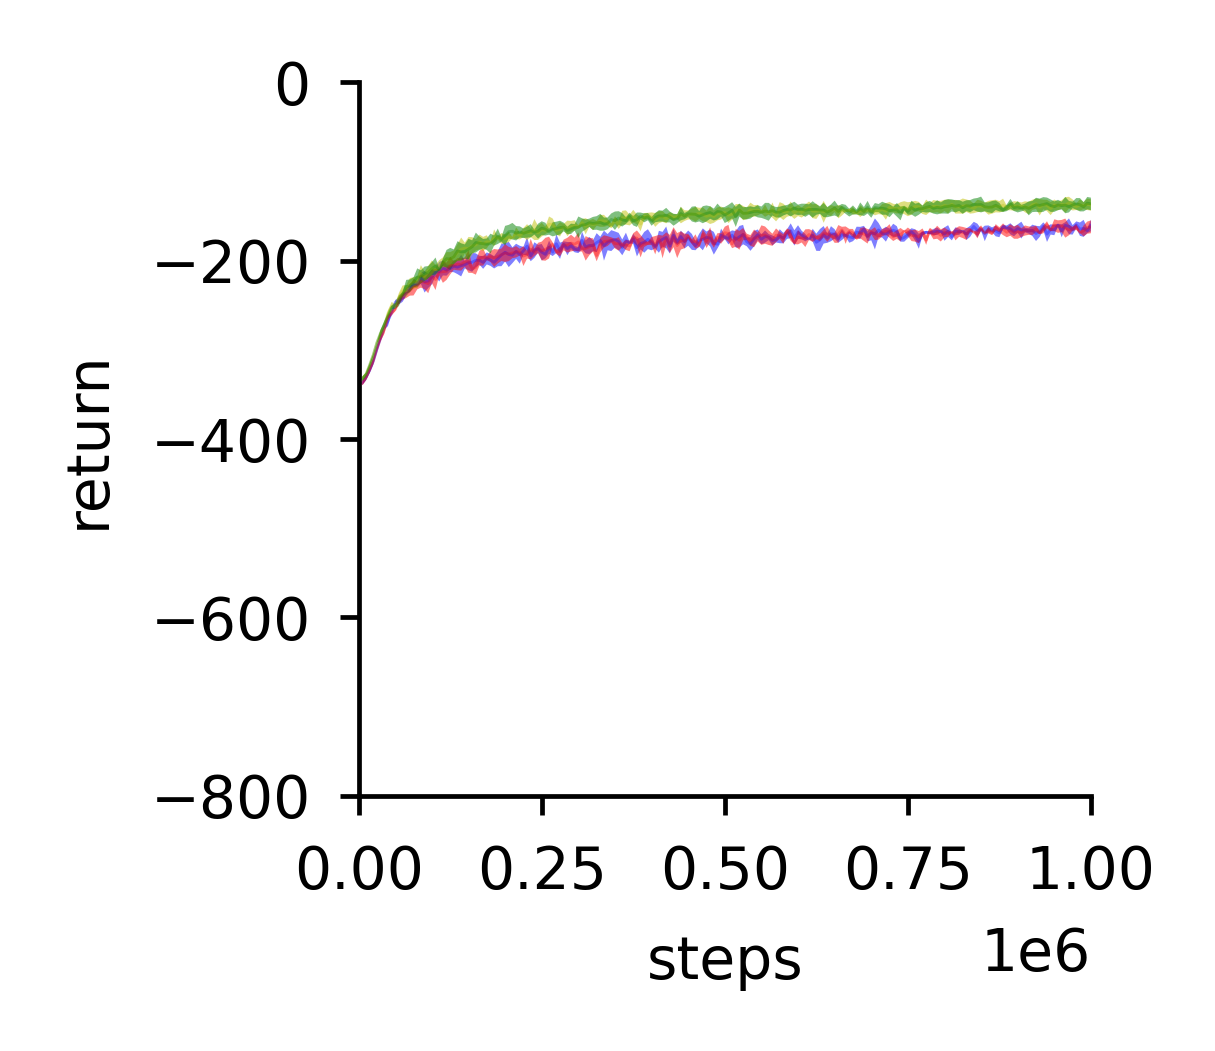

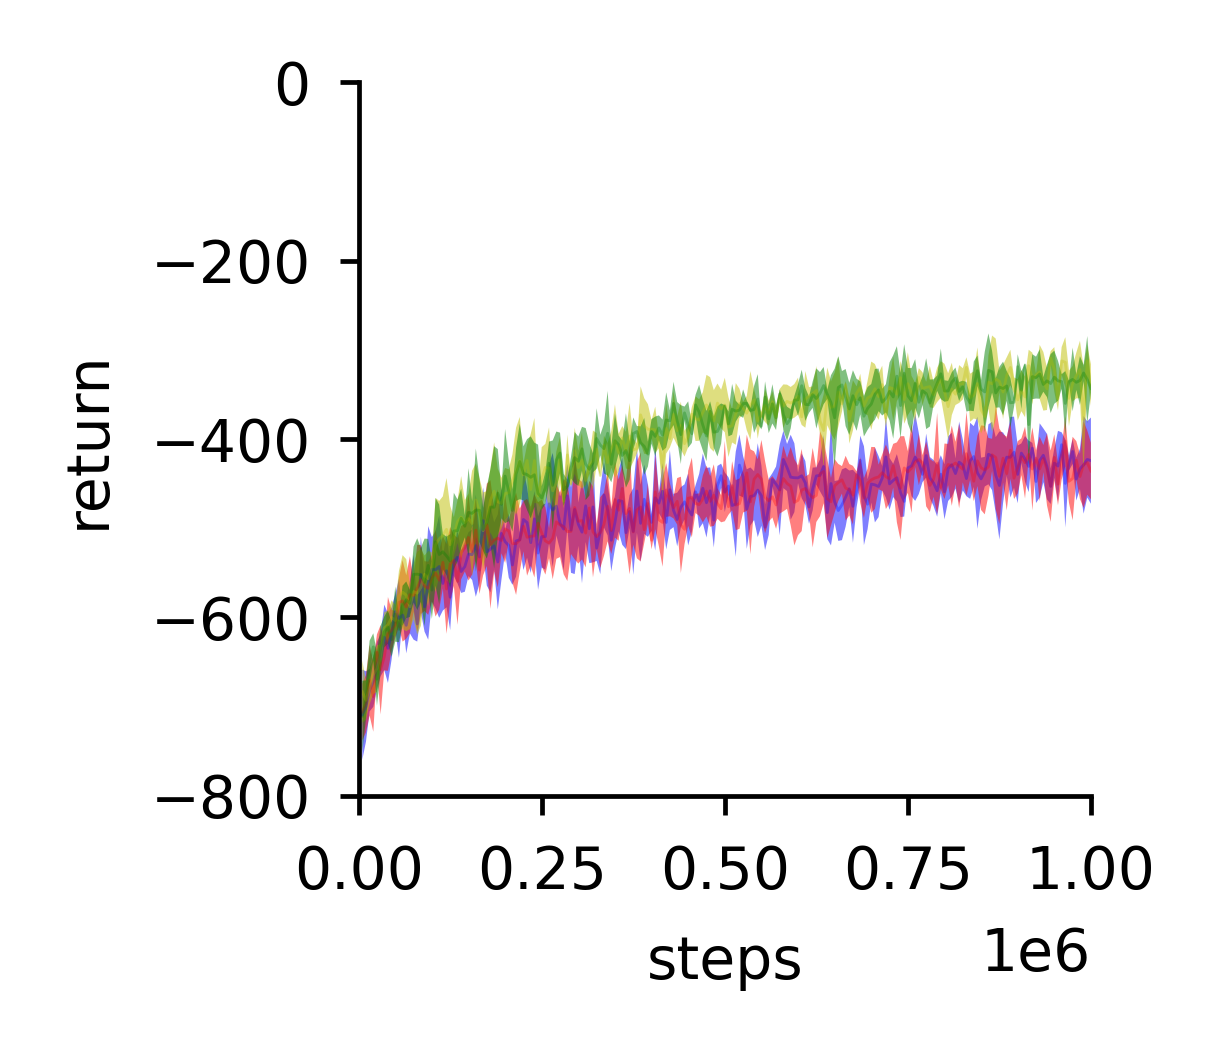

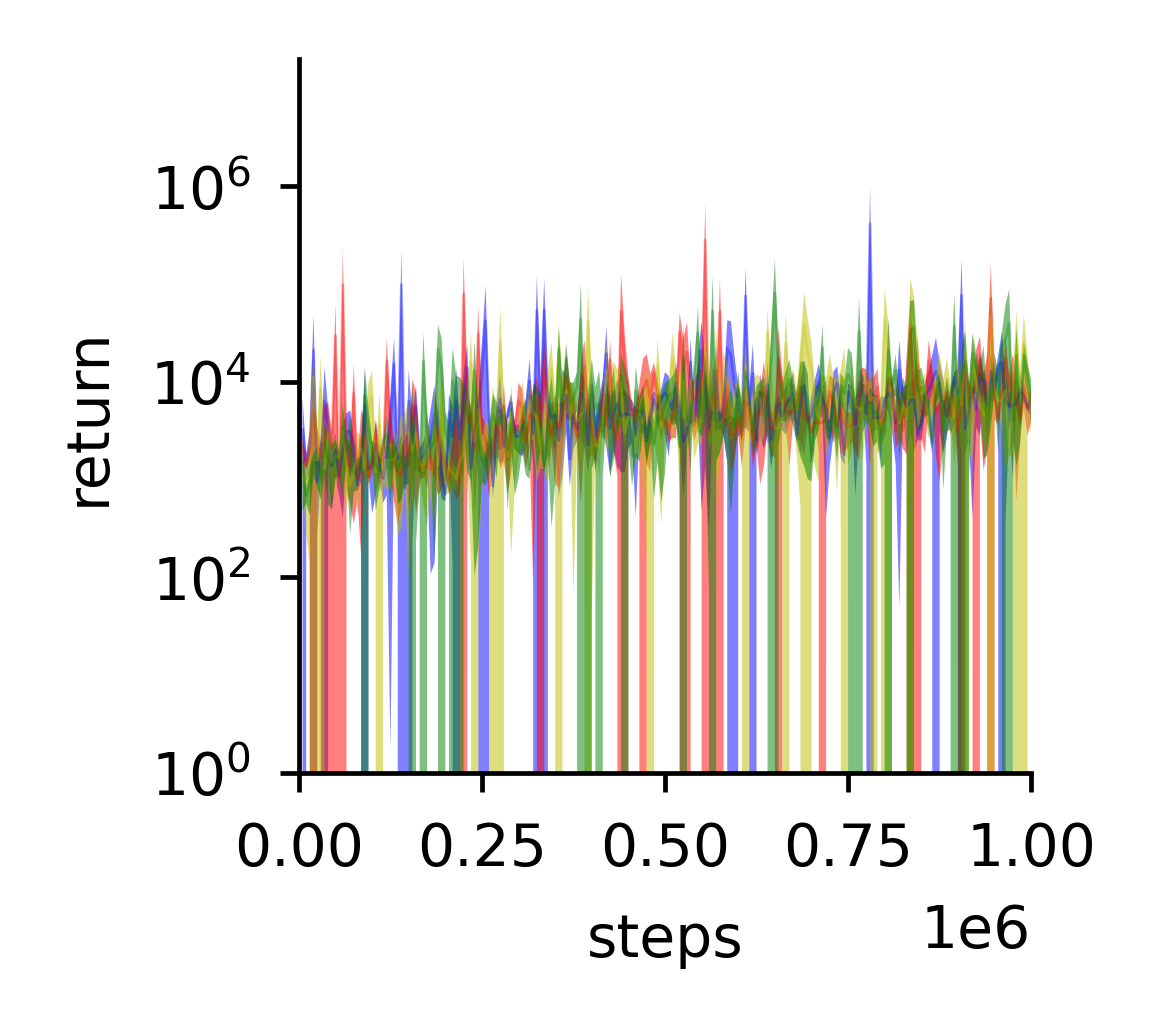

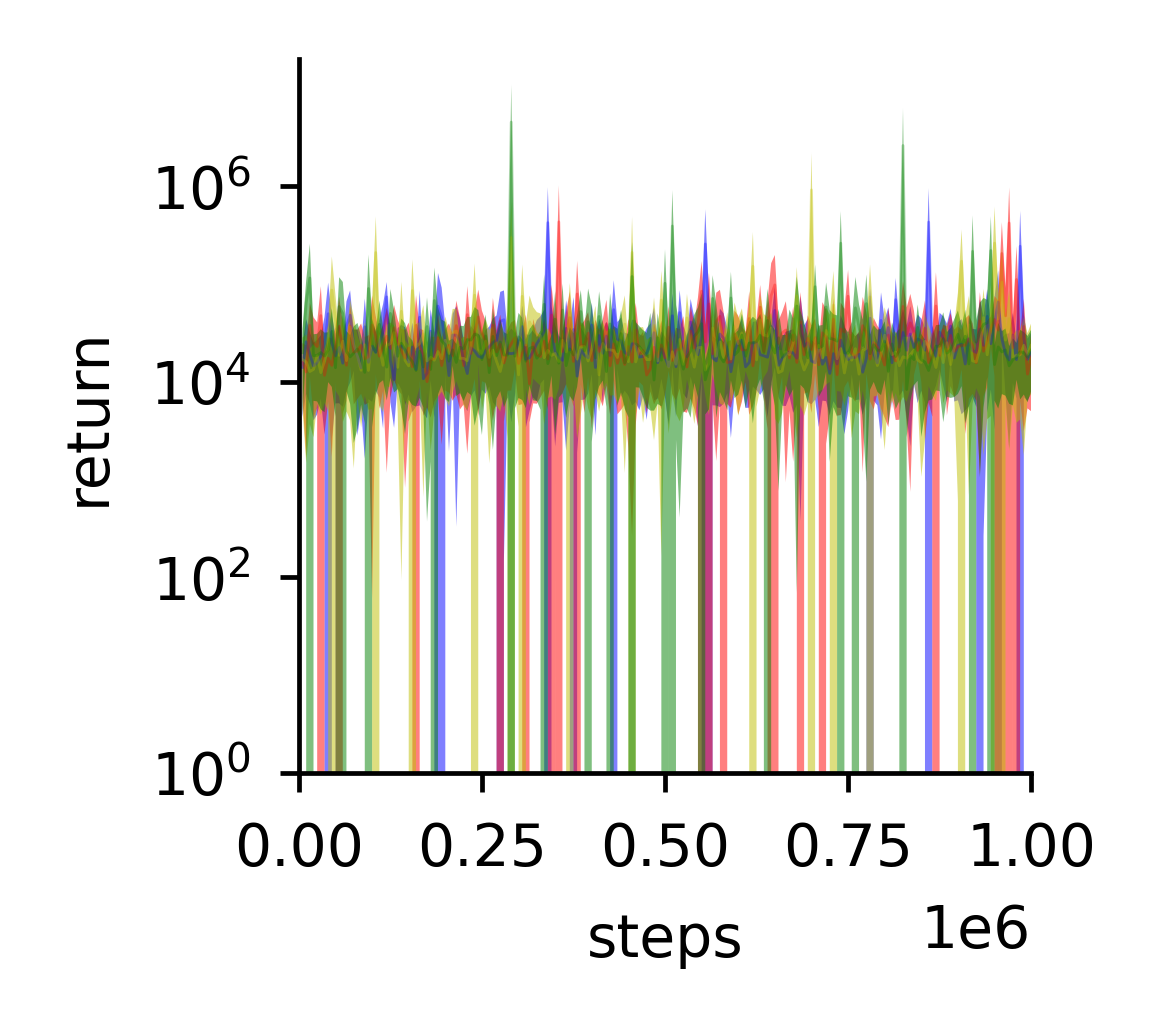

In [423]:
plot_learning_cureve(0.5, 'target')
plot_learning_cureve(1.5, 'target')
plot_learning_cureve(0.5, 'PCA')
plot_learning_cureve(1.5, 'PCA')

In [433]:
# 保存していたrenderを可視化
def render_result(JJ_DEF, REWARD_MODE):
    render_train128 = [None]*3
    render_val128 = [None]*3
    render_train32 = [None]*3
    render_val32 = [None]*3

    for SEED in range(3):
        render_train128[SEED] = np.load('./results/render_epsode_train_JJ{}_{}_obs{}_eps0_seed{}.npy'.format(JJ_DEF, REWARD_MODE, 128, SEED))
        render_val128[SEED] = np.load('./results/render_epsode_val_JJ{}_{}_obs{}_eps0_seed{}.npy'.format(JJ_DEF, REWARD_MODE, 128, SEED))
        render_train32[SEED] = np.load('./results/render_epsode_train_JJ{}_{}_obs{}_eps0_seed{}.npy'.format(JJ_DEF, REWARD_MODE, 32, SEED))
        render_val32[SEED] = np.load('./results/render_epsode_val_JJ{}_{}_obs{}_eps0_seed{}.npy'.format(JJ_DEF, REWARD_MODE, 32, SEED))

    plt.figure(figsize=(20,15))
    plt.imshow(render_val128[0], aspect=2.0)
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(20,15))
    plt.imshow(render_val32[0], aspect=2.0)
    plt.axis('off')
    plt.show()

JJ 0.5 target


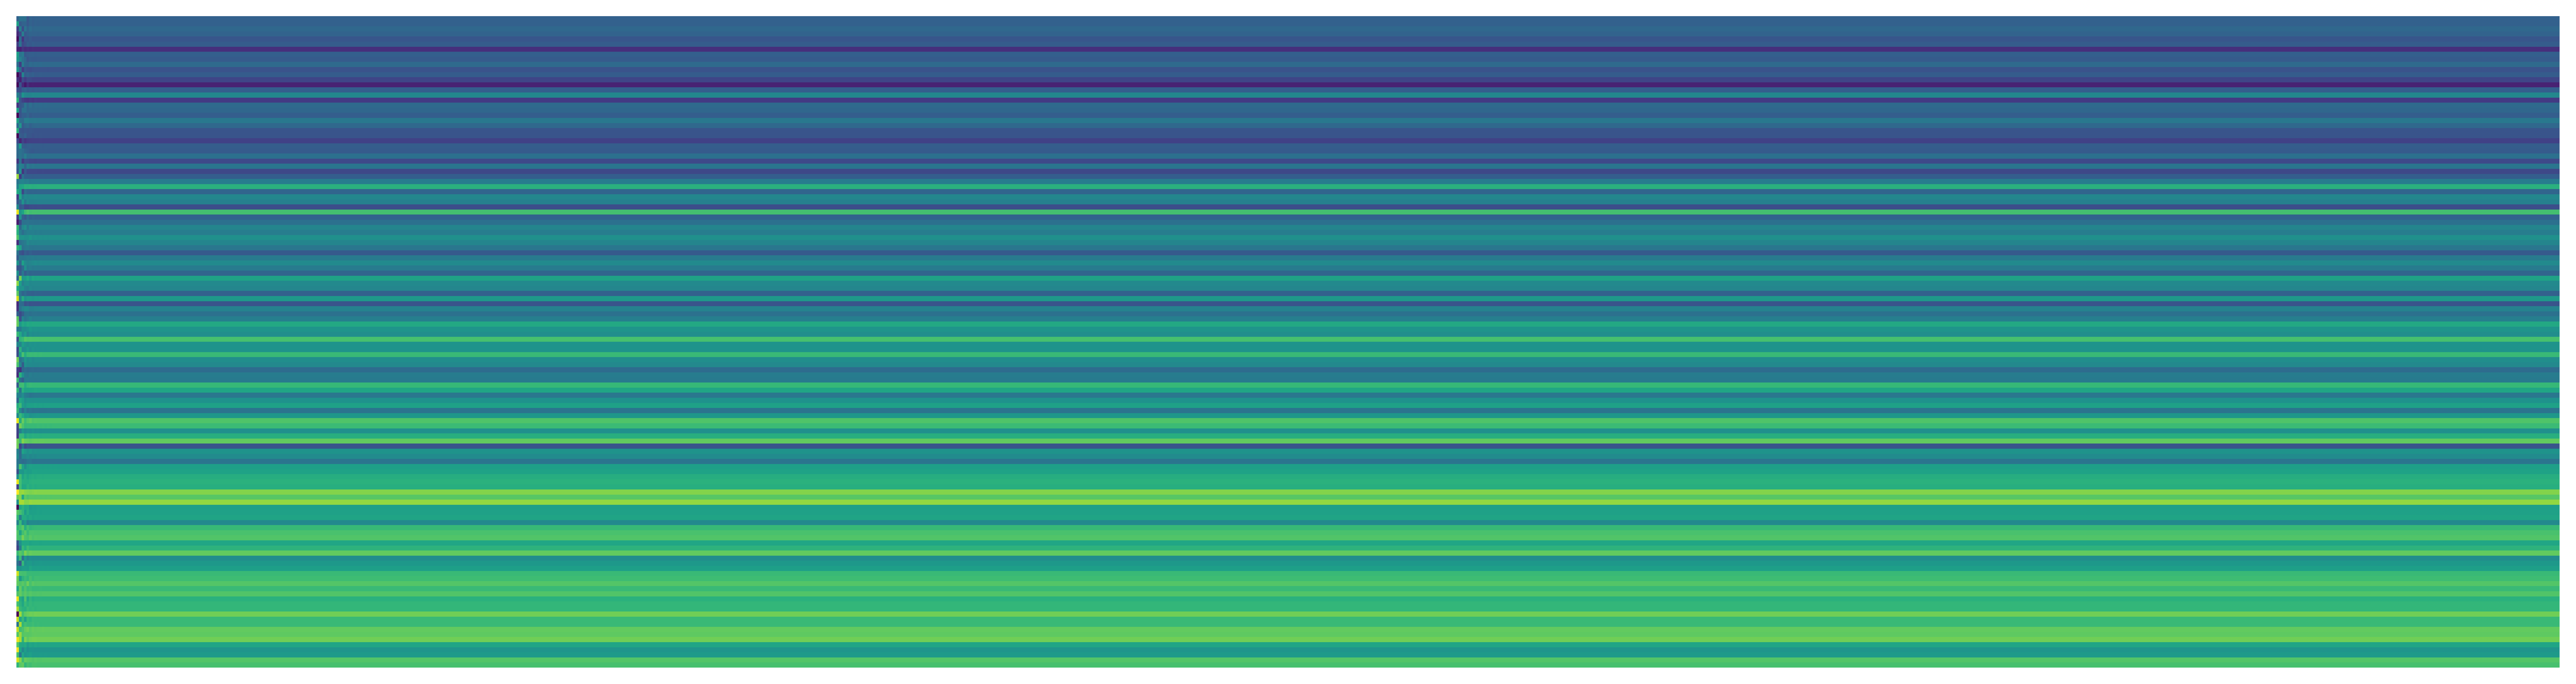

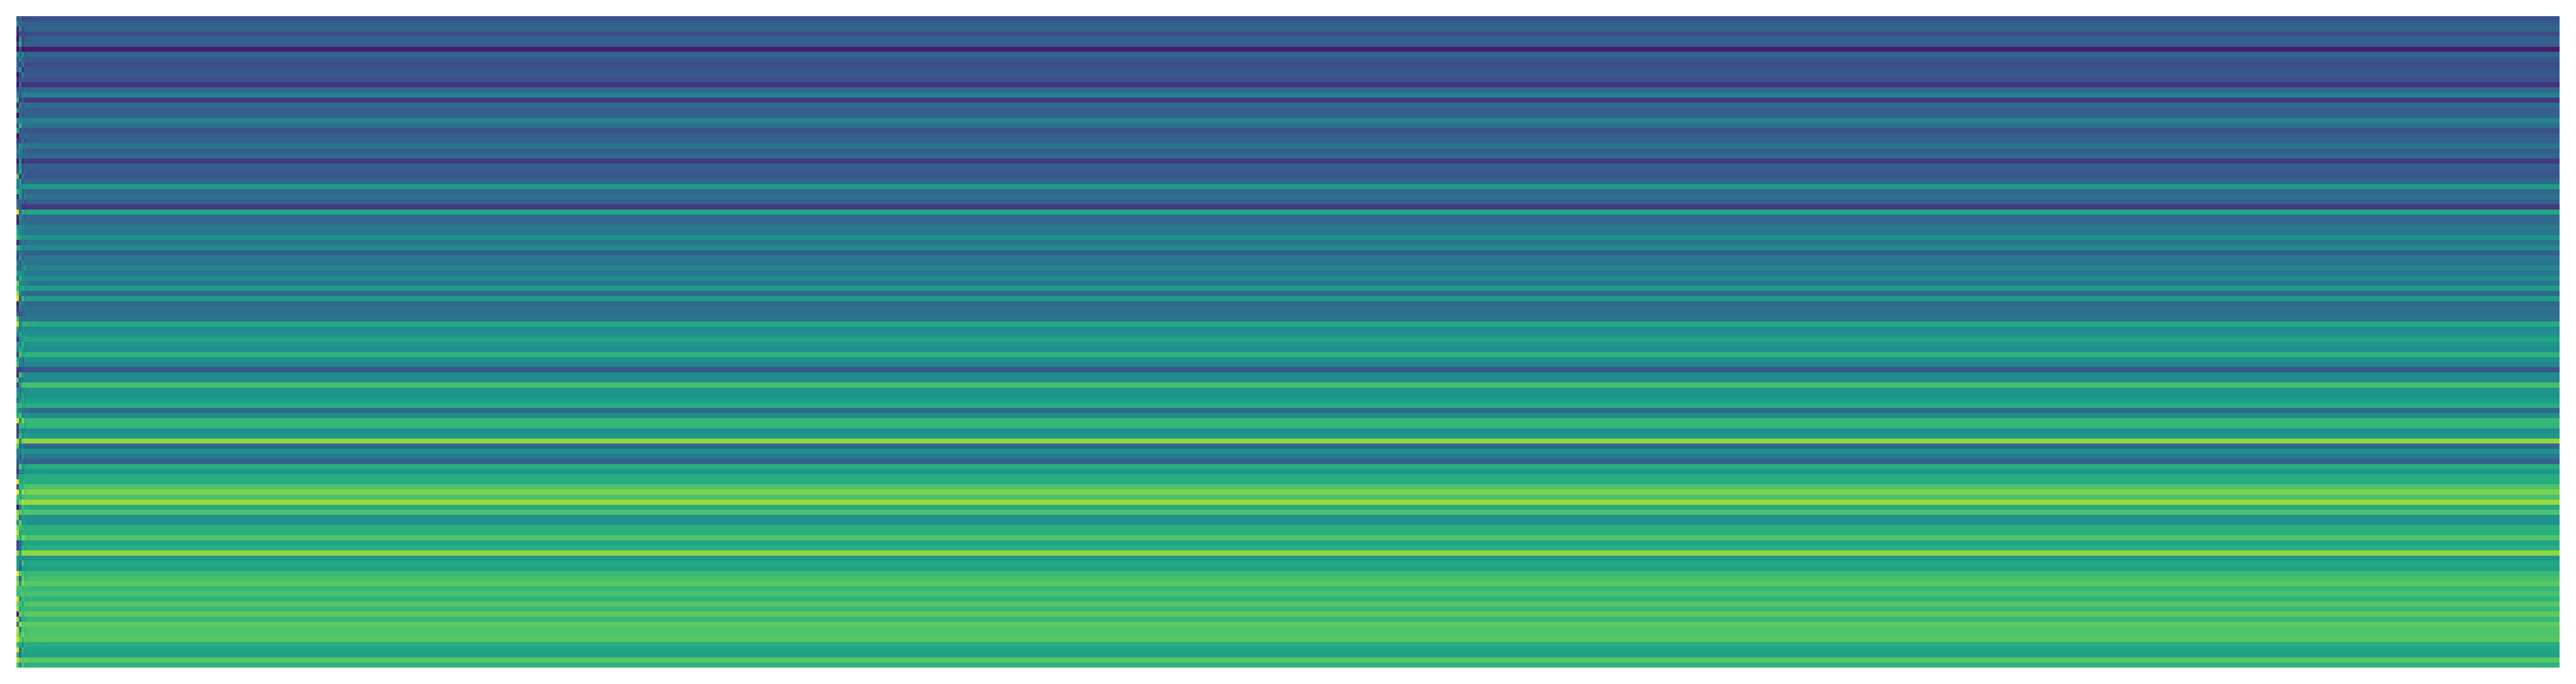

JJ 1.5 target


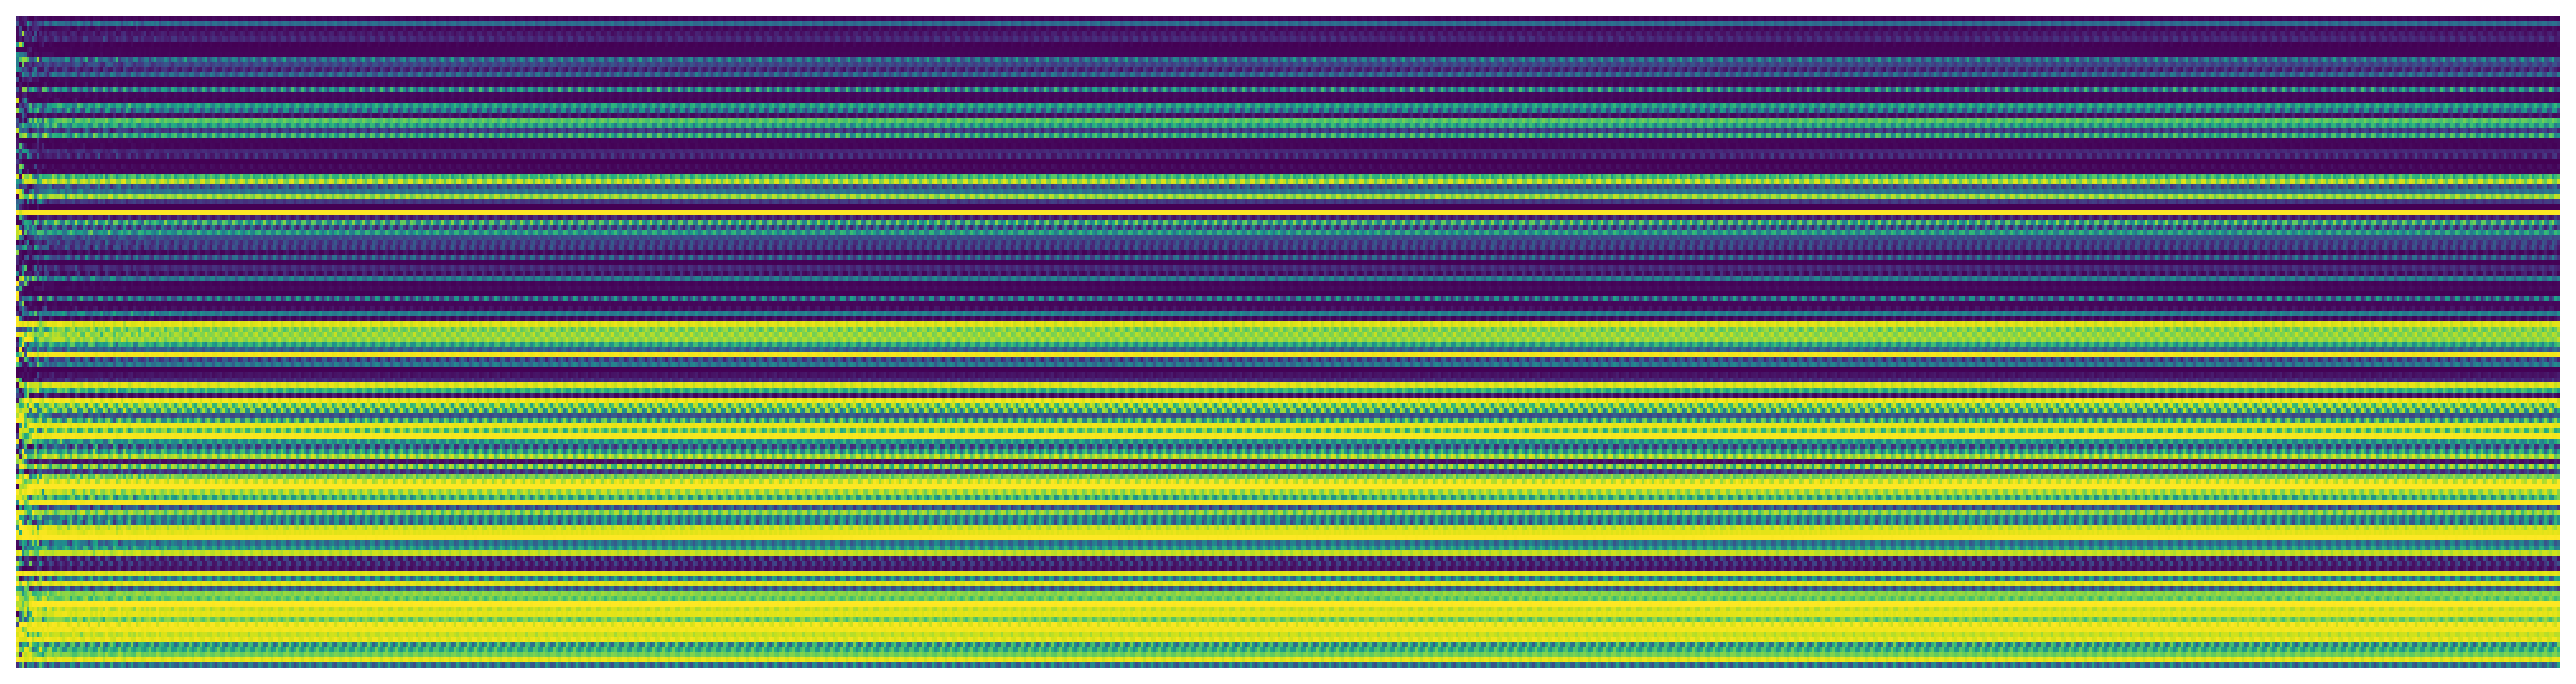

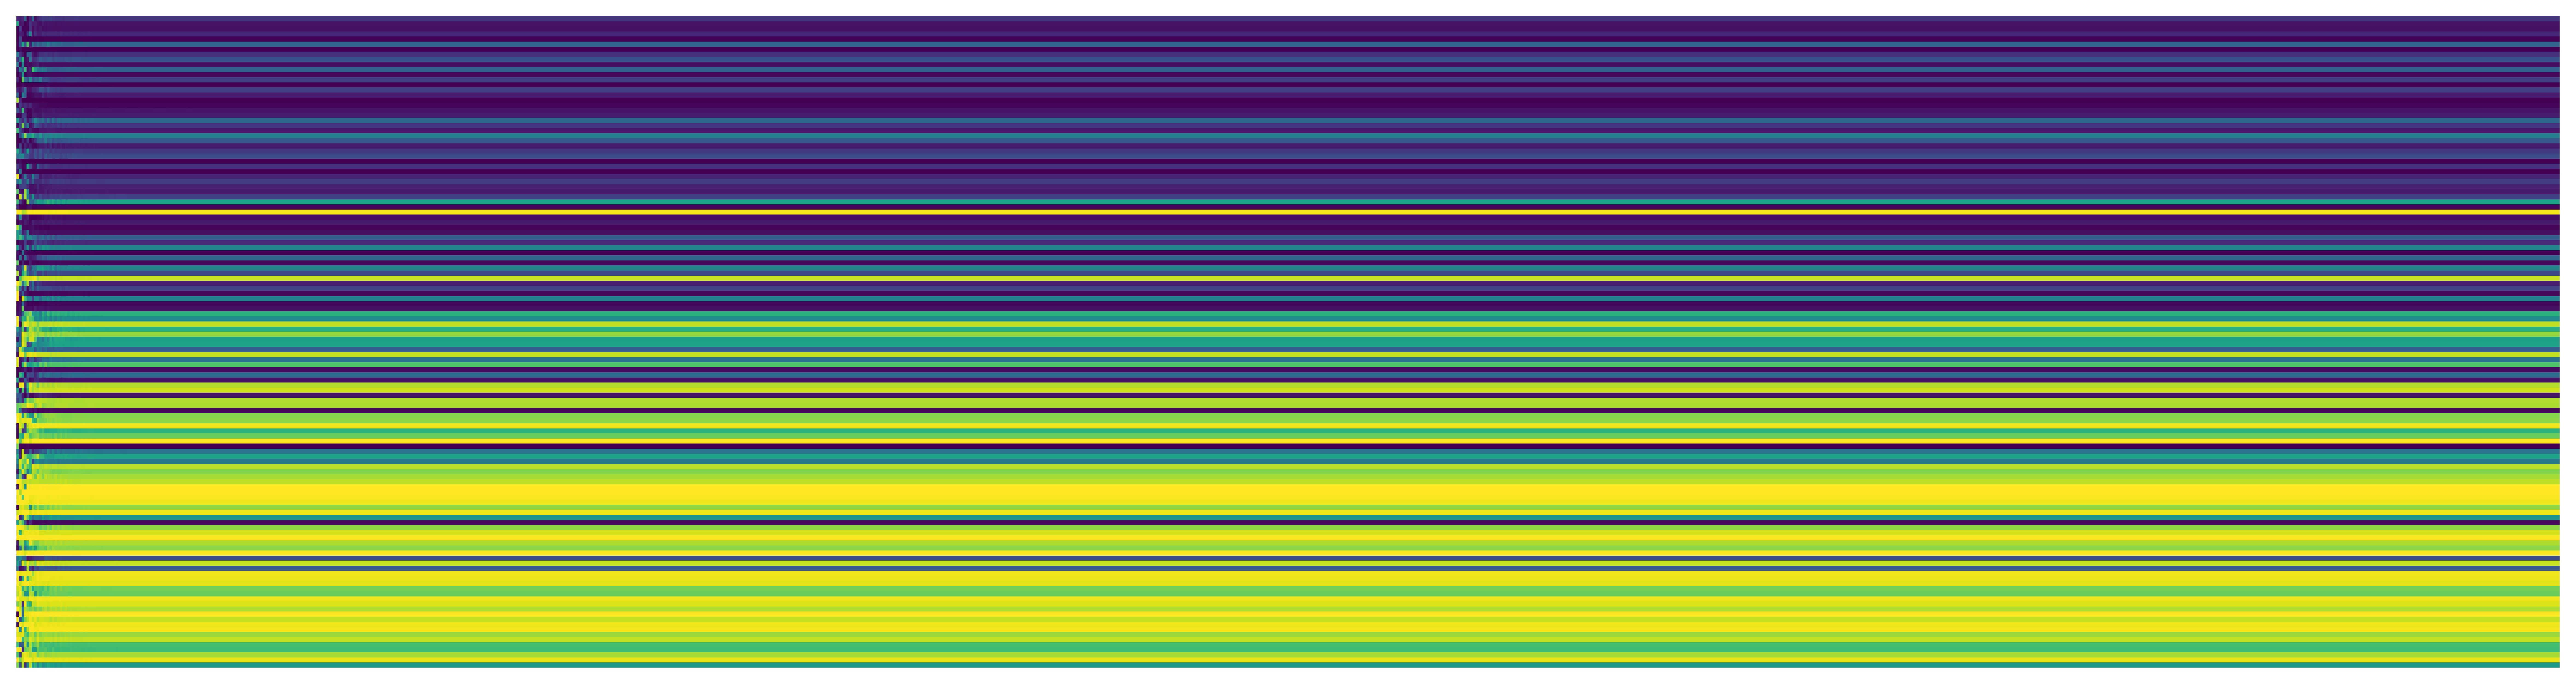

JJ 0.5 PCA


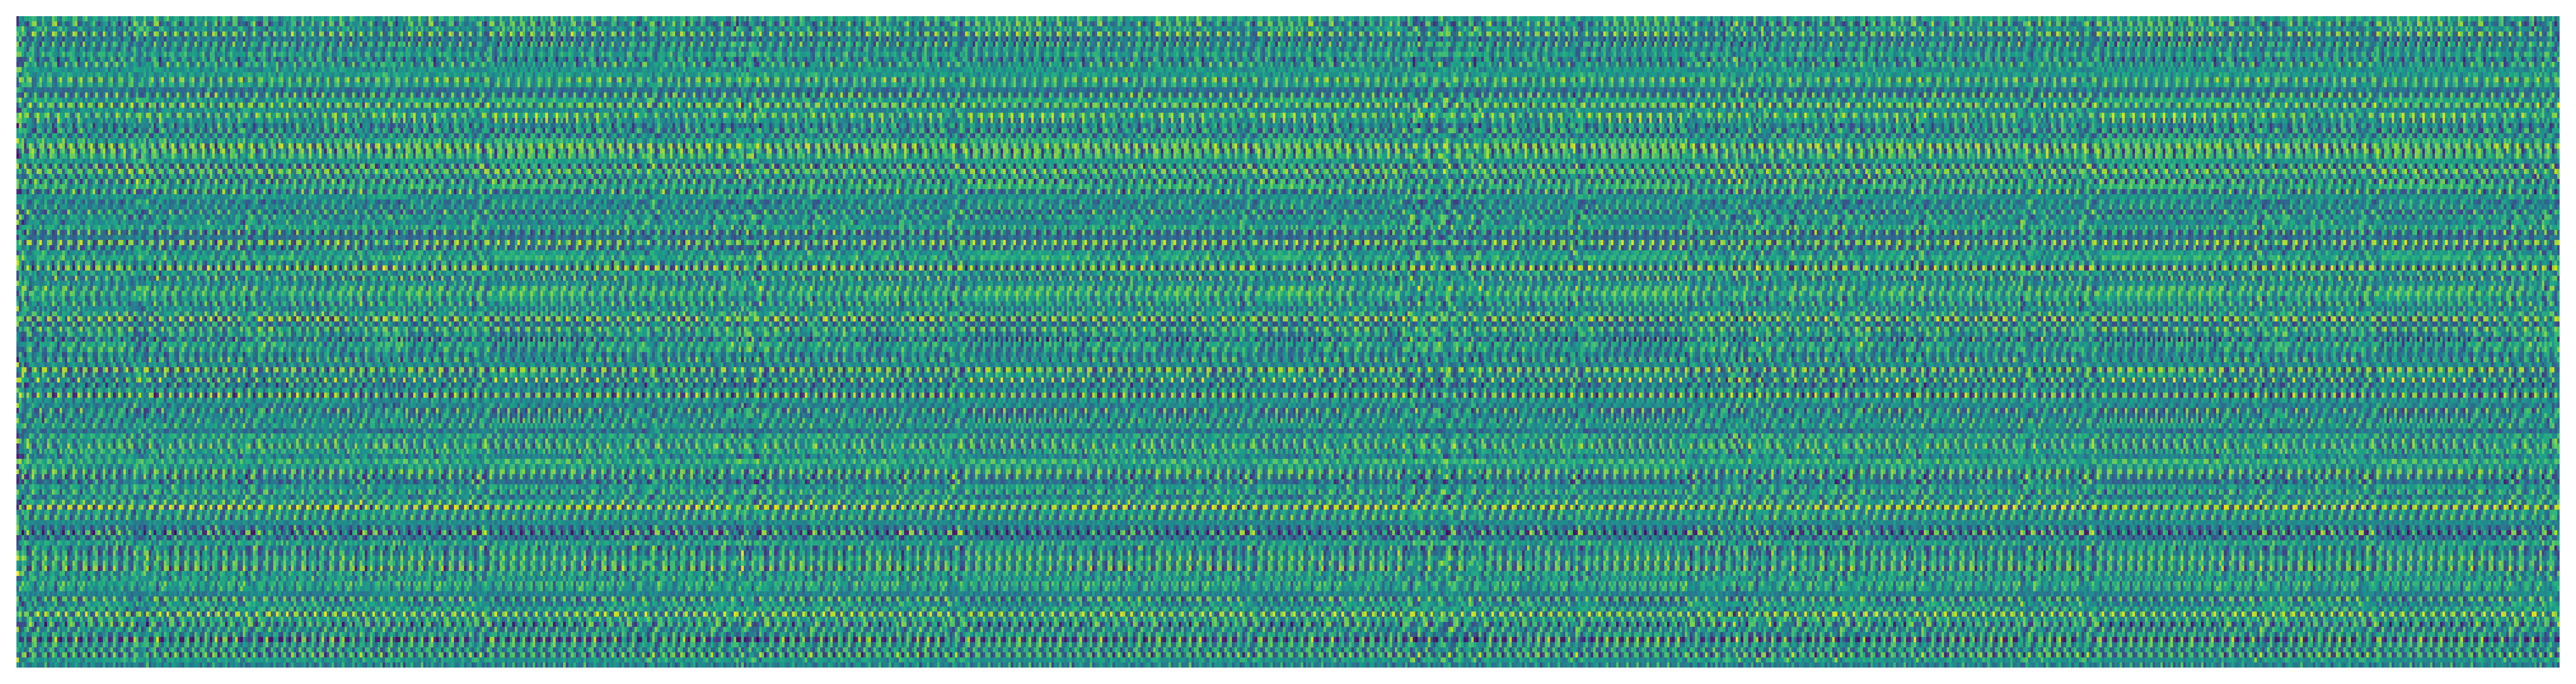

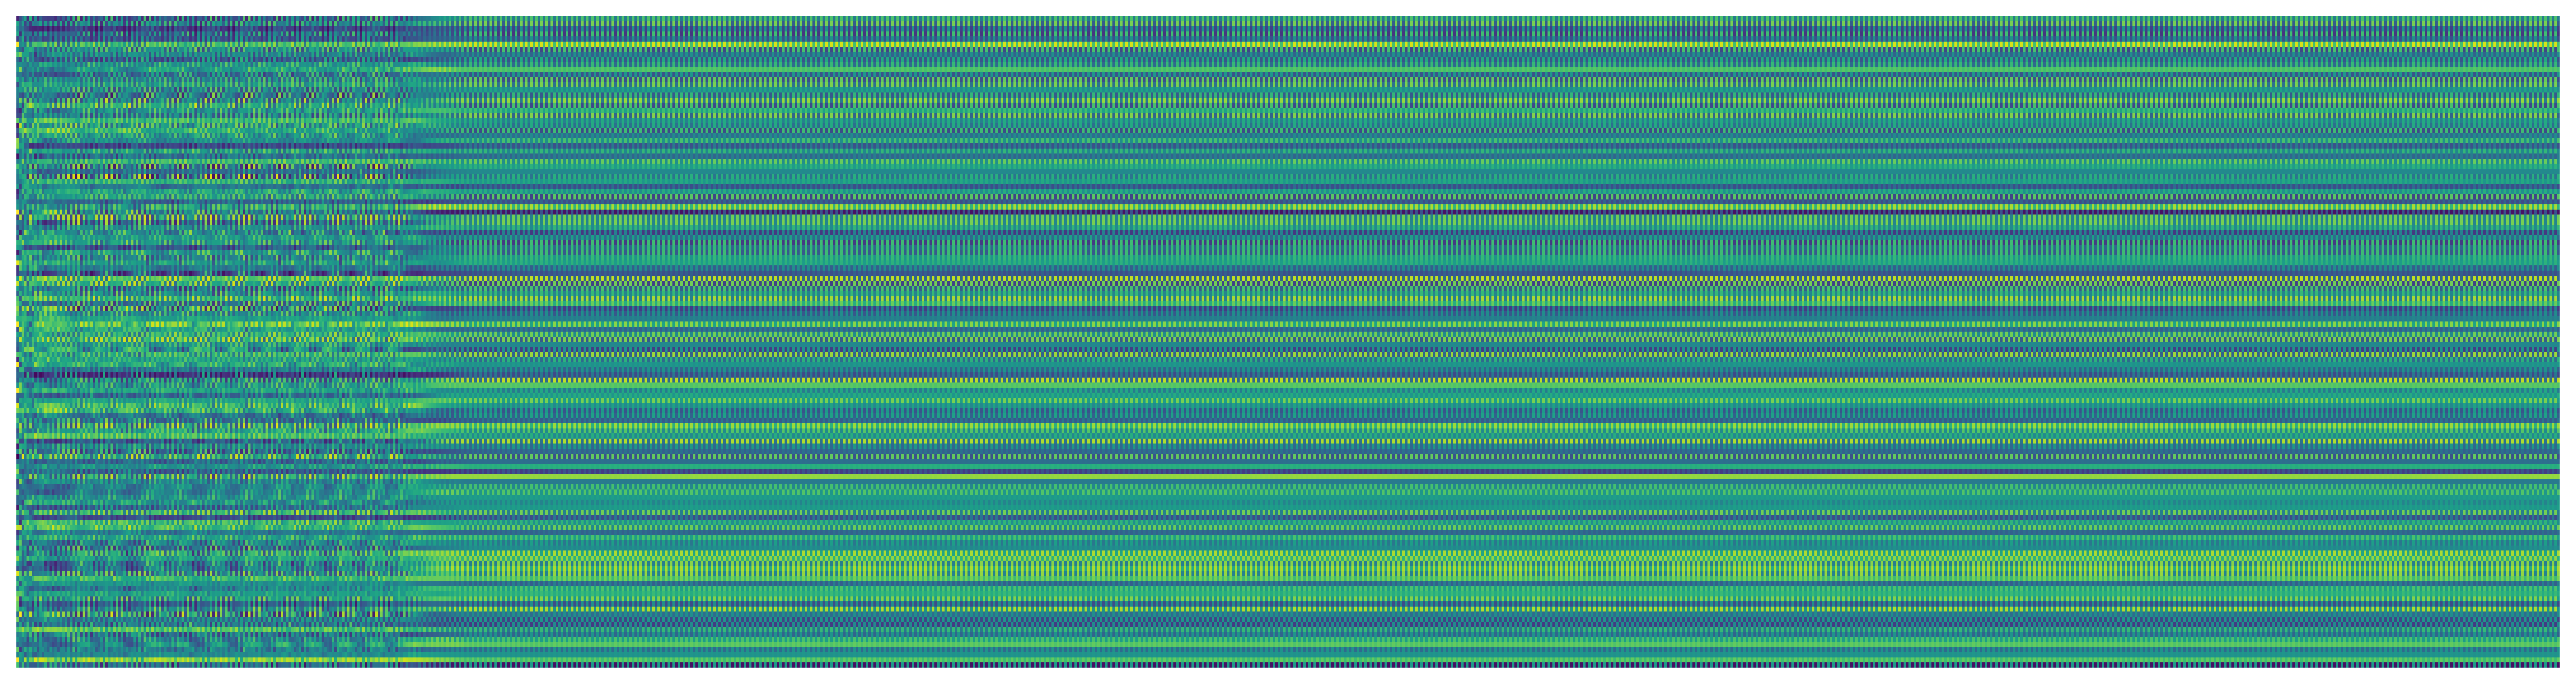

JJ 1.5 PCA


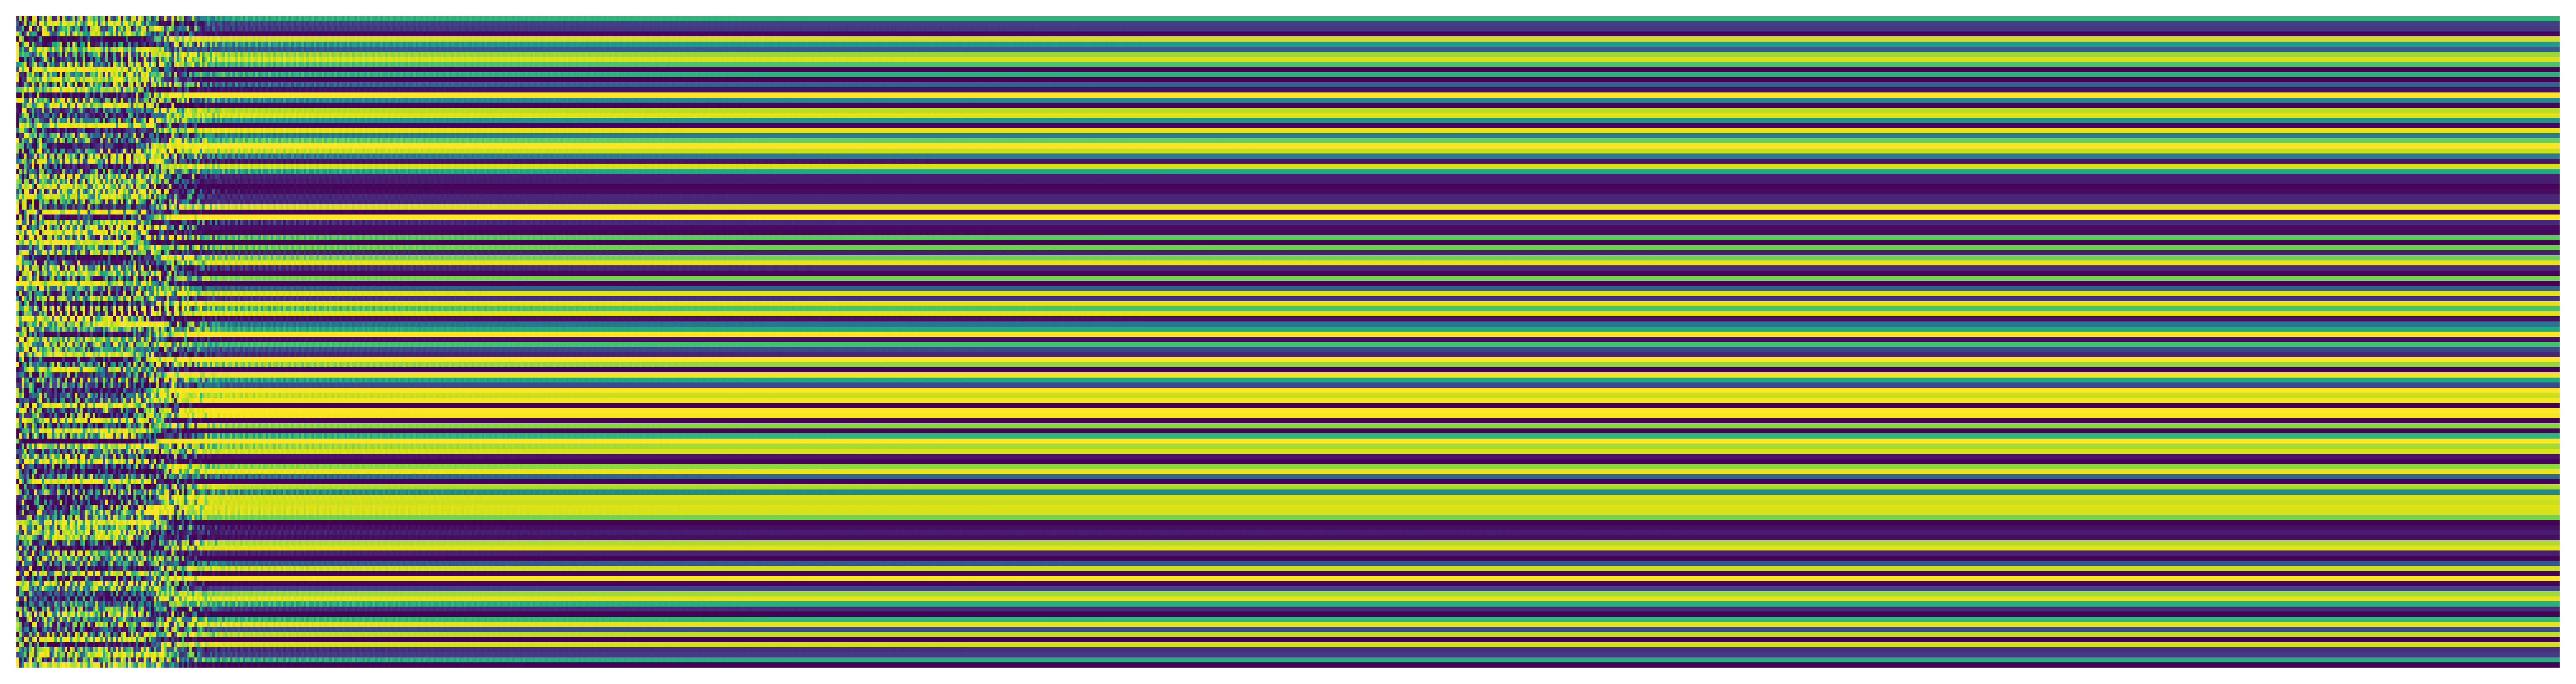

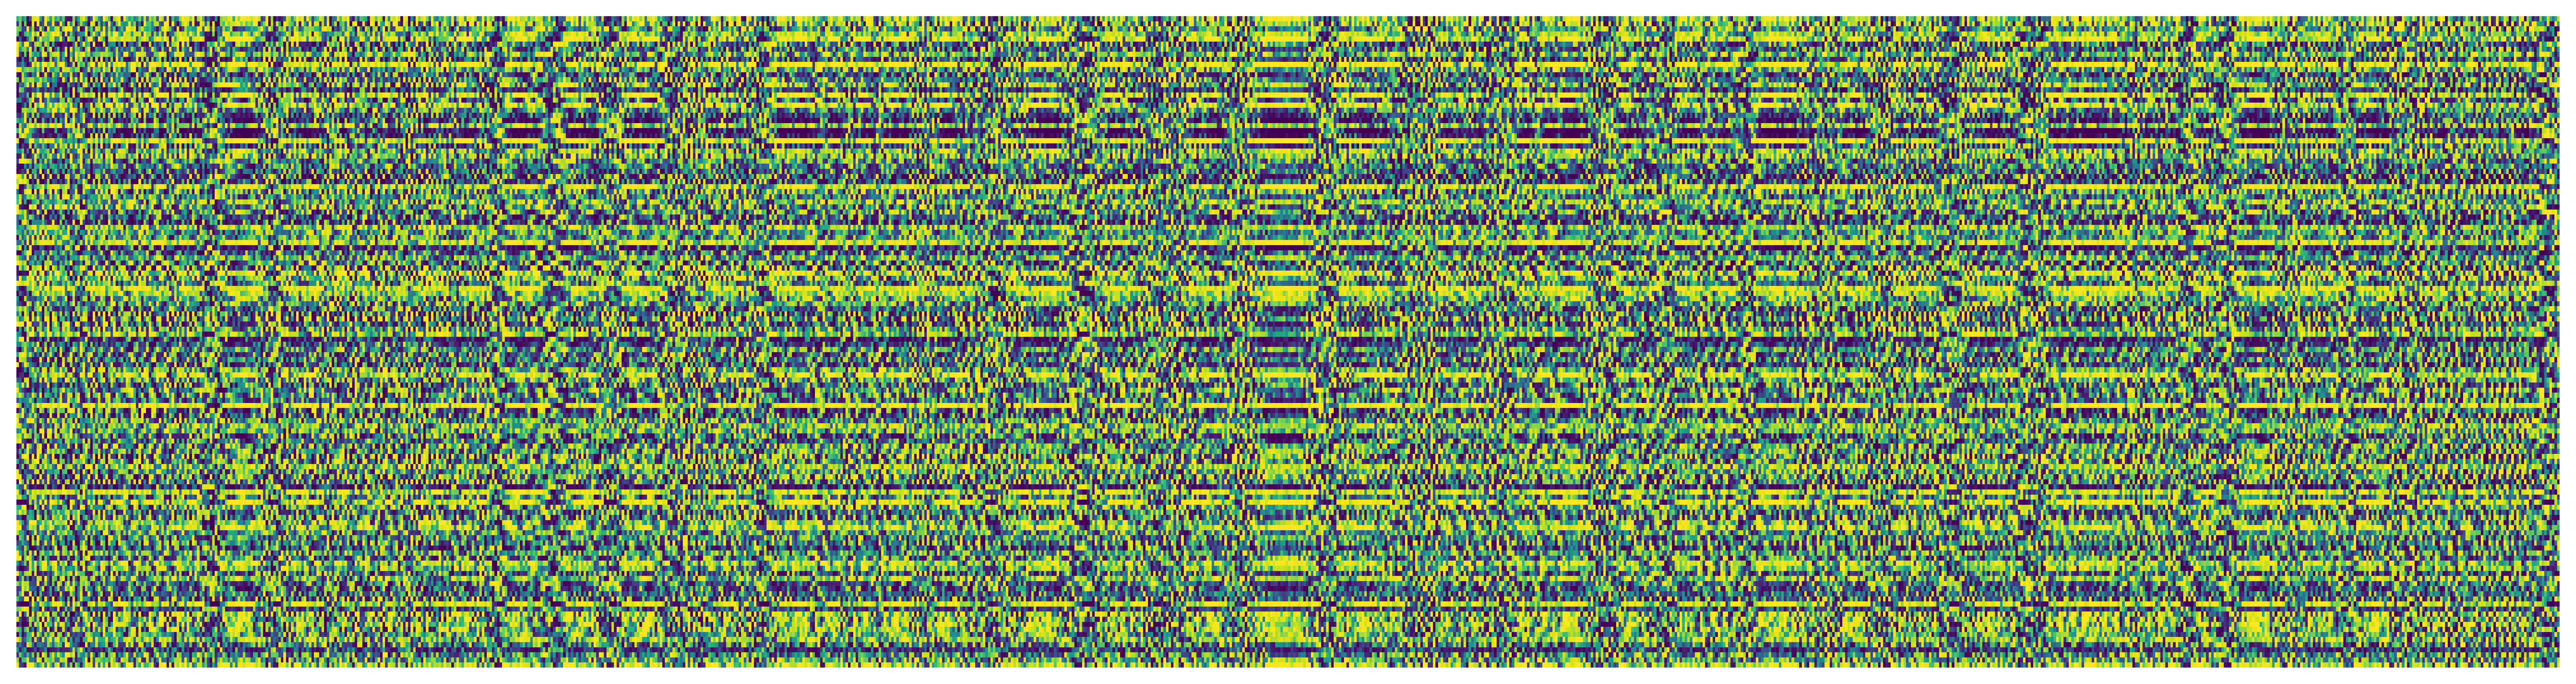

In [434]:
print('JJ 0.5 target')
render_result(0.5, 'target')
print('JJ 1.5 target')
render_result(1.5, 'target')
print('JJ 0.5 PCA')
render_result(0.5, 'PCA')
print('JJ 1.5 PCA')
render_result(1.5, 'PCA')

# モデルベース強化学習の実装
##### 今回はRSを試す

In [449]:
import math
import numpy as np
from scipy.signal import lfilter
import gym
from cpprb import ReplayBuffer
import torch
from torch import nn

In [450]:
N_UNITS = 128
DIM_PCA = 39
N_OBS = N_UNITS
N_STIM_UNITS = 128

In [451]:
# ダイナミクスモデル
class DynamicsModel(torch.nn.Module):
    def __init__(self, input_dim=N_OBS+N_STIM_UNITS, output_dim=N_OBS, units=(96, 96)):
        super().__init__()

        # 隠れ層2層のMLP
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, units[0]),
            torch.nn.ReLU(),
            torch.nn.Linear(units[0], units[1]),
            torch.nn.ReLU(),
            torch.nn.Linear(units[1], output_dim)
        )

        self._loss_fn = torch.nn.MSELoss(reduction='mean')
        self._optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)

    def predict(self, inputs):
        assert inputs.ndim == 2
        return self.model(inputs)

    def fit(self, inputs, labels):
        predicts = self.predict(inputs)
        loss = self._loss_fn(predicts, labels)
        self._optimizer.zero_grad()
        loss.backward()
        self._optimizer.step()
        return loss.data.numpy()
    
    # ダイナミクスモデルを用いた次状態の予測
    def predict_next_state(self, obses, acts):
        assert obses.shape[0] == acts.shape[0]
        # ダイナミクスモデルへの入力は状態と行動の Concata
        inputs = np.concatenate([obses, acts], axis=1)
        inputs = torch.from_numpy(inputs).float()

        # ダイナミクスモデルの出力は次の状態と現在の状態との差分
        obs_diffs = dynamics_model.predict(inputs).data.numpy()
        assert obses.shape == obs_diffs.shape
        next_obses = obses + obs_diffs
        return next_obses

In [458]:
# 報酬関数の定義
def reward_fn(obses, target):
    mse = ((obses - np.tile(target, (obses.shape[0],1)))**2).mean()
    return -mse

# ランダム方策
class RandomPolicy:
    def __init__(self, max_action, act_dim):
        self._max_action = max_action  # action の最大値
        self._act_dim = act_dim  # action の次元数

    def get_actions(self, batch_size):
        # 一様分布からバッチサイズ分ランダムにサンプリング
        return np.random.uniform(
            low=-self._max_action,
            high=self._max_action,
            size=(batch_size, self._act_dim))


# RSの実装
def random_shooting(policy, dynamics_model, env, init_obs, n_mpc_episodes=2**10, horizon=5):
    init_actions = policy.get_actions(batch_size=n_mpc_episodes)

    returns = np.zeros(shape=(n_mpc_episodes,))
    obses = np.tile(init_obs, (n_mpc_episodes, 1))

    # horizon分未来まで予測
    for i in range(horizon):
        # 行動の生成。最初のステップ目の時のみ上記 init_actions を使う（上書きしない）
        acts = init_actions if i == 0 else policy.get_actions(batch_size=n_mpc_episodes)

        # ダイナミクスモデルを用いた次状態の予測
        next_obses = dynamics_model.predict_next_state(obses, acts)

        # 報酬は事前に定義した報酬関数を用いる
        rewards = reward_fn(next_obses, env.reward_target)
        returns += rewards
        obses = next_obses

    # 最も累積報酬が高かった最初の行動を返す
    return init_actions[np.argmax(returns)]  

In [459]:
# ダイナミクスモデルの学習用関数の定義
def fit_dynamics(dynamics_buffer, dynamics_model, n_iter=50, batch_size=100):
    mean_loss = 0.
    for _ in range(n_iter):
        samples = dynamics_buffer.sample(batch_size)
        inputs = np.concatenate([samples["obs"], samples["act"]], axis=1)
        labels = samples["next_obs"] - samples["obs"]
        mean_loss += dynamics_model.fit(
            torch.from_numpy(inputs).float(),
            torch.from_numpy(labels).float())
    return mean_loss

def pre_training(env, dynamics_buffer, dynamics_model, n_iter=1000):
    total_steps = 0

    # ダイナミクスモデルの事前学習のために実環境でランダムに遷移を収集
    for _ in range(10):
        obs = env.reset()
        for _ in range(1000):
            total_steps += 1
            act = env.action_space.sample()
            next_obs, _, done, _ = env.step(act)
            dynamics_buffer.add(obs=obs, act=act, next_obs=next_obs)
            obs = next_obs
            if done:
                break
    # ダイナミクスモデルの事前学習
    fit_dynamics(dynamics_buffer, dynamics_model, n_iter=n_iter)
    return total_steps

def training_func(env, dynamics_buffer, dynamics_model, policy, total_steps, n_episodes=100, n_iter=100):
    
    total_rewards = []
    mean_losses = []
    for episode_idx in range(n_episodes):
        total_rew = 0.

        obs = env.reset()
        for _ in range(env._max_episode_steps):
            total_steps += 1

            # RSを使って1ステップだけ進める
            act = random_shooting(policy, dynamics_model, env, obs)
            next_obs, rew, done, _ = env.step(act)

            # 収集した遷移をバッファに保存
            dynamics_buffer.add(obs=obs, act=act, next_obs=next_obs)

            total_rew += rew
            if done:
                break
            obs = next_obs

        # ダイナミクスモデルの更新
        mean_loss = fit_dynamics(dynamics_buffer, dynamics_model, n_iter=n_iter)

        if episode_idx % 5 == 0:
            print("iter={0: 3d} total steps: {1: 5d} total reward: {2: 4.4f} mean loss: {3:.6f}".format(
                episode_idx, total_steps, total_rew, mean_loss))
        total_rewards.append(total_rew)
        mean_losses.append(mean_loss)
    return total_rewards, mean_losses

In [461]:
# 異なるseedで3回訓練
N_UNITS = 128
DIM_PCA = 39
N_OBS = N_UNITS
N_STIM_UNITS = 128
repeat = 3
MAX_STIM = 1
JJ_DEF = 0.5
EPSILON = 0
ROLLOUT_LENGTH = 10**3
T_RENDER = 256

save_path = './results/model_base'
if not os.path.isdir(save_path):
    os.makedirs(save_path)
for SEED in range(repeat):
    env = SompolinskyEnv(Max_stim=MAX_STIM, N_stim_units=N_STIM_UNITS, Max_state=5, N_units=N_UNITS,
                         JJ=JJ_DEF, seed_synapse=0, seed_state=SEED, N_obs=N_OBS, epsilon=EPSILON , T=ROLLOUT_LENGTH,
                         reward_mode='target', reward_target=np.linspace(-1, 1, N_UNITS), T_render=T_RENDER, dim_pca=DIM_PCA)
    # 10Kデータ分 (s, a, s') を保存できるリングバッファを用意します
    rb_dict = {
        "size": 10**4,
        "default_dtype": np.float32,
        "env_dict": {
            "obs": {"shape": env.observation_space.shape},
            "next_obs": {"shape": env.observation_space.shape},
            "act": {"shape": env.action_space.shape}}}
    dynamics_buffer = ReplayBuffer(**rb_dict)
    dynamics_model = DynamicsModel(input_dim=N_OBS + N_STIM_UNITS, output_dim=N_OBS)
    policy = RandomPolicy(
        max_action=env.action_space.high[0],
        act_dim=env.action_space.high.size)
    total_steps = pre_training(env, dynamics_buffer, dynamics_model, n_iter=1000)
    total_rew, mean_loss = training_func(env, dynamics_buffer, dynamics_model, policy, total_steps, n_episodes=100, n_iter=100)
    np.save('./results/model_base/total_reward_{}.npy'.format(SEED), total_rew)
    np.save('./results/model_base/mean_loss_{}.npy'.format(SEED), mean_loss)

iter=  0 total steps:  11000 total reward: -423.7637 mean loss: 10.179208
iter=  5 total steps:  16000 total reward: -421.1627 mean loss: 10.011765
iter= 10 total steps:  21000 total reward: -424.1830 mean loss: 9.967608
iter= 15 total steps:  26000 total reward: -423.1604 mean loss: 9.855755
iter= 20 total steps:  31000 total reward: -423.8760 mean loss: 9.866915
iter= 25 total steps:  36000 total reward: -423.8269 mean loss: 9.796146
iter= 30 total steps:  41000 total reward: -425.8991 mean loss: 9.693076
iter= 35 total steps:  46000 total reward: -421.4308 mean loss: 9.749497
iter= 40 total steps:  51000 total reward: -423.8056 mean loss: 9.743792
iter= 45 total steps:  56000 total reward: -425.3793 mean loss: 9.747877
iter= 50 total steps:  61000 total reward: -422.6123 mean loss: 9.749948
iter= 55 total steps:  66000 total reward: -423.8821 mean loss: 9.759679
iter= 60 total steps:  71000 total reward: -424.0814 mean loss: 9.707881
iter= 65 total steps:  76000 total reward: -425.2

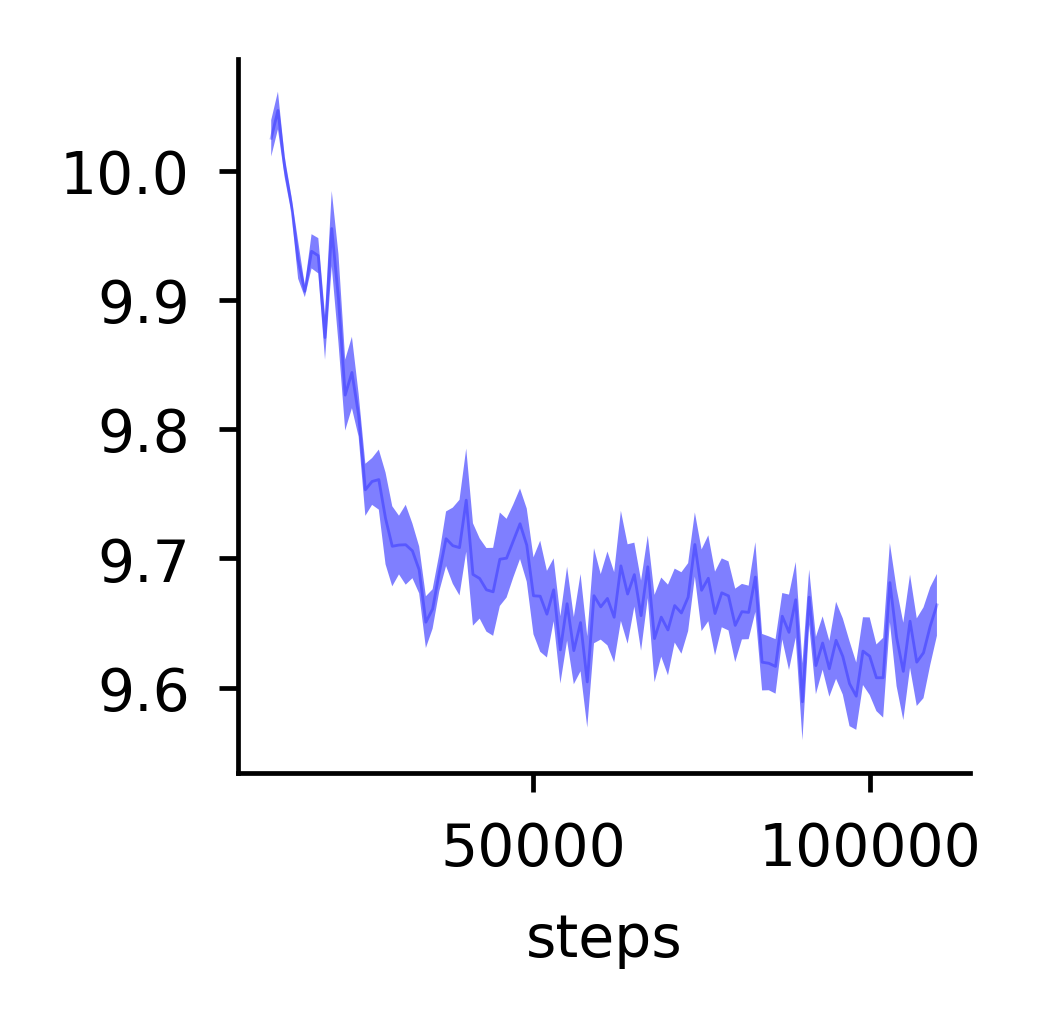

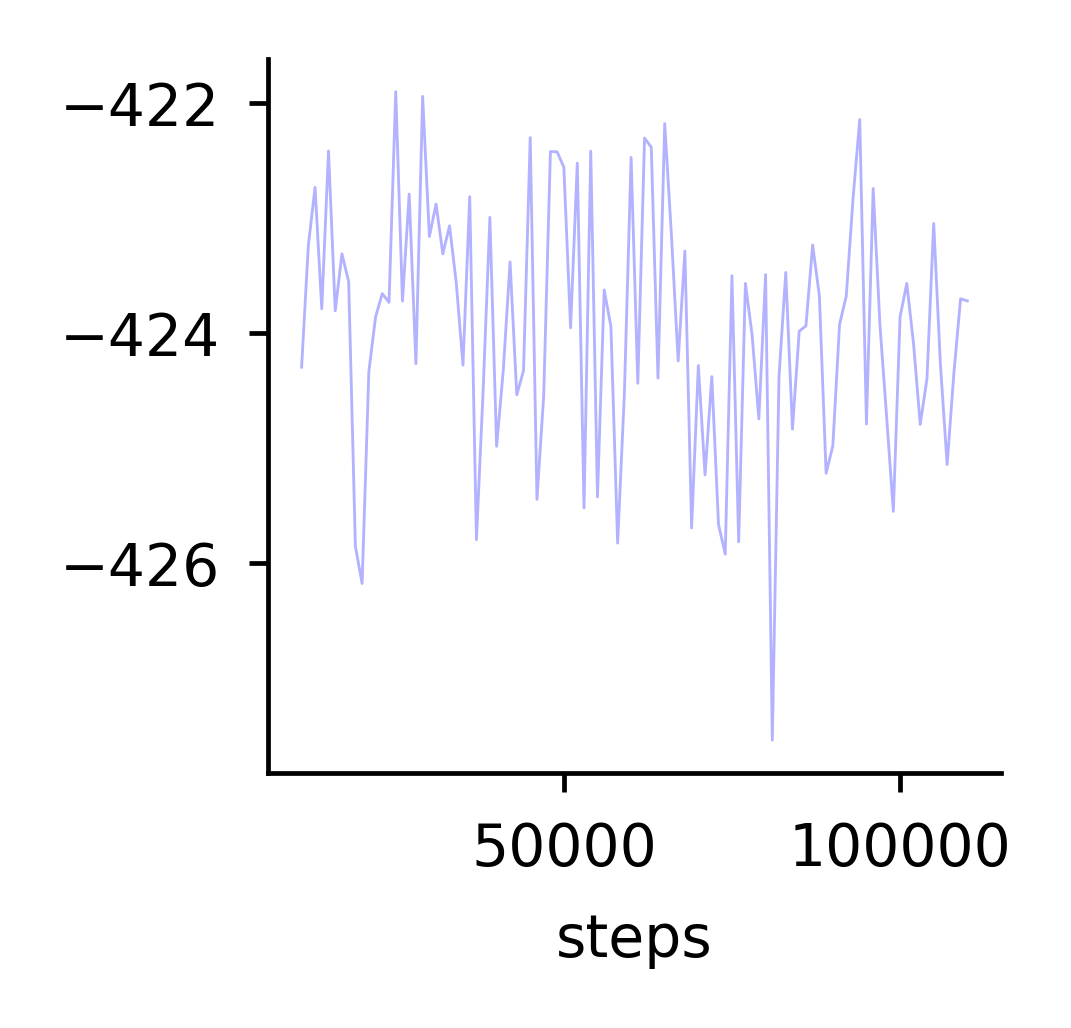

In [457]:
# target,N_OBS=128のみで学習した
mean_losses = [None]*3
total_rewards = [None]*3
for SEED in range(3):
    mean_losses[SEED] = np.load('./results/model_base/mean_loss_{}.npy'.format(SEED))
    total_rewards[SEED] = np.load('./results/model_base/total_reward_{}.npy'.format(SEED))
    
mean_loss_me =  np.mean(mean_losses,axis=0)
mean_loss_sd =  np.std(mean_losses,axis=0)
total_reward_me =  np.mean(total_rewards,axis=0)
total_reward_sd =  np.std(total_rewards,axis=0)
steps = (np.arange(len(mean_loss_me))+1)*1000 + 10000
plt.plot(steps, mean_loss_me,c='b',alpha=0.3)
plt.fill_between(steps,mean_loss_me+mean_loss_sd,mean_loss_me-mean_loss_sd,facecolor='b',alpha=0.5)
plt.xlabel('steps')
plt.ylabel('loss')
plt.show()
plt.plot(steps, total_reward_me,c='b',alpha=0.3)
plt.fill_between(steps,total_reward_me+total_reward_sd,total_reward_me-total_reward_sd,facecolor='b',alpha=0.5)
plt.xlabel('steps')
plt.ylabel('return')
plt.show()